#**Detect Emerging Crises from Tweets**
Daisy Khamphakdy, Nathan Martinez

W210, MIDS, UC Berkeley

Dataset: [CrisisMMD](https://crisisnlp.qcri.org/crisismmd)

In [ ]:
#A Colab pro environment should have >20Gb of total memory.
from psutil import virtual_memory
colab_pro = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(colab_pro))

if colab_pro < 20:
  print('Not using a high-RAM runtime')
  # train model with lower settings
else:
  print('You are using a high-RAM runtime!')
  # train model with higher settings

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.4 MB/s eta 0:00:00


In [ ]:
# Import packages and set up other settings
import os
import glob
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from io import StringIO
import altair as alt
! pip install "vegafusion[embed]"
import vegafusion as vf
vf.enable(row_limit=50000)
from IPython.display import HTML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm, preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, hamming_loss, precision_score, f1_score, precision_recall_fscore_support
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
!pip install scikit-multilearn
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
# For preprocessing and basic text analysis
! pip install tweet_preprocessor # for preprocessing
import preprocessor as p
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.probability import FreqDist
from nltk.classify.scikitlearn import SklearnClassifier
nltk.download('punkt');
# For BERT
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
# For smote
! pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.9 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Import drive
from google.colab import drive
drive.mount('/content/drive')

# Change the directory
#os.chdir("/content/drive/MyDrive/W210")
#os.chdir("/content/drive/My Drive/210 Capstone: Detect Emerging Crises from Tweets/TREC-IS")
os.chdir("/content/drive/My Drive/Colab Notebooks/210 Capstone Project")

Mounted at /content/drive


In [ ]:
# Upolad and Read both dataframes
file_name_1 = "train.json"
file_name_2 = "val.json"
#io.StringIO[file_name].decode("utf-8")
df_a = pd.read_json(file_name_1, lines = True)
df_b = pd.read_json(file_name_2, lines = True)

# Combine dataframes (concat)
df = pd.concat([df_a, df_b])
df.head()

,event_id,post_id,text,categories,priority,timestamp
0,typhoonHagupit2014,541638434994266112,Photo: Prayers for the Philippines! #Hagupit h...,"Report-FirstPartyObservation,Report-Multimedia...",Low,2018-09-24 16:03:31+00:00
1,hurricaneFlorence2018,1040384290901700608,Hurricane Safety Tip #2: Protect your home fro...,Other-Irrelevant,Low,2019-04-02 18:38:58+00:00
2,fireYMM2016,727137040362426368,Smoke has really thickened over #ymm in the pa...,"Report-MultimediaShare,Report-Hashtags",Low,2019-04-05 16:38:51+00:00
3,nepalEarthquake2015,592073589760851968,@ravikamdar get your argument straight \n\nFra...,Other-Irrelevant,Low,2018-09-07 18:11:12+00:00
4,fireYMM2016,727577686437044224,Crews from Lesser Slave Lake department are he...,"Report-MultimediaShare,Report-Hashtags,Report-...",Low,2019-04-08 16:06:36+00:00


In [ ]:
df.shape

(40459, 6)

In [ ]:
df.describe()

,post_id
count,4.045900e+04
mean,8.226952e+17
std,3.010742e+17
min,7.267628e+16
25%,5.920722e+17
50%,7.512414e+17
75%,1.122533e+18
max,1.162006e+18


In [ ]:
# Value count for event id
df["event_id"].value_counts()

nepalEarthquake2015               5740
typhoonHagupit2014                3939
parisAttacks2015                  2066
fireYMM2016                       2000
shootingDallas2017                2000
albertaWildfires2019              2000
hurricaneFlorence2018             1999
cycloneKenneth2019                1996
philippinesEarthquake2019         1994
southAfricaFloods2019             1349
coloradoStemShooting2019          1147
flSchoolShooting2018              1118
albertaFloods2013                  722
queenslandFloods2013               709
australiaBushfire2013              677
sandiegoSynagogueShooting2019      636
earthquakeBohol2013                583
typhoonYolanda2013                 564
bostonBombings2013                 535
brooklynBlockPartyShooting2020     479
daytonOhioShooting2020             475
siberianWildfires2020              474
athensEarthquake2020               473
indonesiaEarthquake2020            470
gilroygarlicShooting2020           470
myanmarFloods2020        

In [ ]:
# Value count for event id
unique_cat = len(df["categories"].unique())
print("There are", unique_cat, "unique multi-label categories")

There are 3231 unique multi-label categories


In [ ]:
# Value count for event id
df["categories"].value_counts()

Other-Irrelevant                                                                                                    9001
Report-FirstPartyObservation,Other-Sentiment                                                                        1508
Other-Sentiment                                                                                                     1473
Report-Hashtags,Other-Sentiment                                                                                     1303
Other-Discussion                                                                                                     562
                                                                                                                    ... 
Report-Weather,Report-Location,Report-NewSubEvent,Report-MultimediaShare,Report-ServiceAvailable,Report-Hashtags       1
Request-GoodsServices,Request-InformationWanted,CallToAction-Donations,Report-Location,Report-Factoid                  1
Report-EmergingThreats,Report-Mu

In [ ]:
# Value count for priority level
df["priority"].value_counts()

Low         30254
Medium       5933
High         3823
Critical      449
Name: priority, dtype: int64

In [ ]:
# Create binary columns to check if lable is informative - only represents classifications with one label
df['not_informative'] = df['categories'].isin(["Other-Irrelevant"]).astype(int)

df['not_informative'].value_counts()

0    31458
1     9001
Name: not_informative, dtype: int64

## EDA - similar to other dataset

In [ ]:
# Additional chart - altair version
P1 = alt.Chart(df).mark_bar().encode(
    x = alt.X('count():Q', title = "Number of Tweets"),
    y = alt.Y('not_informative:N', title = "Not Informative", sort=alt.EncodingSortField(field="not_informative", op="count", order='descending'))
).properties(title='Tweets by Informative Status', height = 500, width = 600).interactive()

P1

alt.Chart(...)

In [ ]:
df.head()

,event_id,post_id,text,categories,priority,timestamp,not_informative
0,typhoonHagupit2014,541638434994266112,Photo: Prayers for the Philippines! #Hagupit h...,"Report-FirstPartyObservation,Report-Multimedia...",Low,2018-09-24 16:03:31+00:00,0
1,hurricaneFlorence2018,1040384290901700608,Hurricane Safety Tip #2: Protect your home fro...,Other-Irrelevant,Low,2019-04-02 18:38:58+00:00,1
2,fireYMM2016,727137040362426368,Smoke has really thickened over #ymm in the pa...,"Report-MultimediaShare,Report-Hashtags",Low,2019-04-05 16:38:51+00:00,0
3,nepalEarthquake2015,592073589760851968,@ravikamdar get your argument straight \n\nFra...,Other-Irrelevant,Low,2018-09-07 18:11:12+00:00,1
4,fireYMM2016,727577686437044224,Crews from Lesser Slave Lake department are he...,"Report-MultimediaShare,Report-Hashtags,Report-...",Low,2019-04-08 16:06:36+00:00,0


Text(0, 0.5, 'Disaster Event Labels')

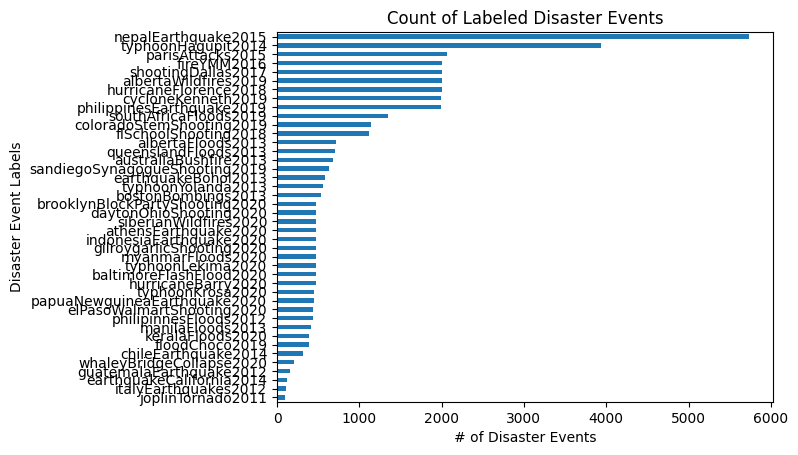

In [ ]:
df_c = df.event_id.value_counts().sort_values().plot(kind='barh')
plt.title('Count of Labeled Disaster Events')
plt.xlabel('# of Disaster Events')
plt.ylabel('Disaster Event Labels')


In [ ]:
event = df.event_id.unique()
print(*event, sep = "\n")

typhoonHagupit2014
hurricaneFlorence2018
fireYMM2016
nepalEarthquake2015
shootingDallas2017
coloradoStemShooting2019
australiaBushfire2013
cycloneKenneth2019
philippinesEarthquake2019
parisAttacks2015
flSchoolShooting2018
southAfricaFloods2019
albertaFloods2013
albertaWildfires2019
queenslandFloods2013
typhoonYolanda2013
guatemalaEarthquake2012
manilaFloods2013
floodChoco2019
sandiegoSynagogueShooting2019
italyEarthquakes2012
earthquakeCalifornia2014
chileEarthquake2014
bostonBombings2013
earthquakeBohol2013
philipinnesFloods2012
joplinTornado2011
gilroygarlicShooting2020
whaleyBridgeCollapse2020
myanmarFloods2020
keralaFloods2020
daytonOhioShooting2020
elPasoWalmartShooting2020
typhoonLekima2020
indonesiaEarthquake2020
siberianWildfires2020
baltimoreFlashFlood2020
papuaNewguineaEarthquake2020
hurricaneBarry2020
typhoonKrosa2020
athensEarthquake2020
brooklynBlockPartyShooting2020


In [ ]:
event_names = ["Typhoon Hagupit",
"Hurricane Florence",
"Fire Fort McMurray",
"Nepal Earthquake",
"Shooting Dallas",
'Colorado Stem Shooting',
'Australia Bushfire',
"Cyclone Kenneth",
"Philippines Earthquake",
"Paris Attacks",
"Parkland School Shooting",
'South Africa Floods',
"Alberta Floods"
"Alberta Wildfires",
"Queensland Floods",
"Typhoon Yolanda"]
# guatemalaEarthquake2012
# manilaFloods2013
# floodChoco2019
# sandiegoSynagogueShooting2019
# italyEarthquakes2012
# earthquakeCalifornia2014
# chileEarthquake2014
# bostonBombings2013
# earthquakeBohol2013
# philipinnesFloods2012
# joplinTornado2011
# gilroygarlicShooting2020
# whaleyBridgeCollapse2020
# myanmarFloods2020
# keralaFloods2020
# daytonOhioShooting2020
# elPasoWalmartShooting2020
# typhoonLekima2020
# indonesiaEarthquake2020
# siberianWildfires2020
# baltimoreFlashFlood2020
# papuaNewguineaEarthquake2020
# hurricaneBarry2020
# typhoonKrosa2020
# athensEarthquake2020
# brooklynBlockPartyShooting2020)

for x in event_names:
  print(x)

Typhoon Hagupit
Hurricane Florence
Fire Fort McMurray
Nepal Earthquake
Shooting Dallas
Colorado Stem Shooting
Australia Bushfire
Cyclone Kenneth
Philippines Earthquake
Paris Attacks
Parkland School Shooting
South Africa Floods
Alberta FloodsAlberta Wildfires
Queensland Floods
Typhoon Yolanda


In [ ]:
print("Not Informative")
print("Informative")

Not Informative
Informative


## Data Preprocessing
    1. Clean data
    2. Encode labels
    3. Preprocess tweet text
    4. Extract features

    Next steps:
    1. Binary classification of informative vs. not_informative tweets
    2. Classify informative tweets by disaster event (might want to consider using # to identify disaster event)
    3. Classify informative tweets by disaster type
    4. Classify informative tweets by type of aid needed

In [ ]:
# Identify NaN in tweet_text column
df_Nan = df['text'].isnull().sum()
print("There are", df_Nan, "NAs - no action needed")

There are 0 NAs - no action needed


In [ ]:
# Duplicates
dup_text_ids = len(df[df.duplicated(['post_id', 'text'])])
print("There are", dup_text_ids, "duplicate post ids and text - no action needed")

There are 0 duplicate post ids and text - no action needed


In [ ]:
# Use the clean function within the tweet preprocessing package to clean the text
df['tweet_clean'] = df["text"].apply(lambda x: p.clean(x))

df['tweet_clean']

0                     Photo: Prayers for the Philippines!
1       Hurricane Safety Tip : Protect your home from ...
2       Smoke has really thickened over in the past ho...
3       get your argument straight Fraud based convers...
4       Crews from Lesser Slave Lake department are he...
                              ...                        
3376    Why is it that for every story that I see abou...
3377    Are the attacks a response to France's interve...
3378    Oh no, not again..... I?m seeing fires NW, W, ...
3379    : What happened at each location of the Paris ...
3380    "Strong Earthquake Strikes Philippines, Killin...
Name: tweet_clean, Length: 40459, dtype: object

In [ ]:
# Remove extra white spaces, punctuation, and apply lower case
df['tweet_clean'] = df['tweet_clean'].str.lower().str.replace('[^\w\s]',' ', regex = True).str.replace('\s\s+', ' ', regex = True)

df['tweet_clean']

0                      photo prayers for the philippines 
1       hurricane safety tip protect your home from st...
2       smoke has really thickened over in the past ho...
3       get your argument straight fraud based convers...
4       crews from lesser slave lake department are he...
                              ...                        
3376    why is it that for every story that i see abou...
3377    are the attacks a response to france s interve...
3378    oh no not again i m seeing fires nw w and sw o...
3379     what happened at each location of the paris a...
3380     strong earthquake strikes philippines killing...
Name: tweet_clean, Length: 40459, dtype: object

####Oversample imbalanced dataset w/ SMOTE

In [ ]:
# import imblearn
# print(imblearn.__version__)

In [ ]:
# data = df.values
# # split into input and output elements
# X, y = data[:, :-1], data[:, -1]
# # label encode the target variable
# y = LabelEncoder().fit_transform(y)
# # summarize distribution
# counter = Counter(y)
# for k,v in counter.items():
#  per = v / len(y) * 100
#  print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# # plot the distribution
# pyplot.bar(counter.keys(), counter.values())
# pyplot.show()

####Expanding contractions:

In our tweets, we have the words “we will” contracted as “we’ll”, which should be managed before further normalization.

In [ ]:
# #combine all in one cell.
# tweet_clean = df['tweet_clean']
# separator = " "

# # create list of words for each line
# list_of_tweets = []
# for i in tweet_clean:
#     list_of_tweets.append(i)

In [ ]:
# list_of_tweets[:5]

In [ ]:
# contractions_dict = {"ain’t": "are not", "’s":" is", "aren’t": "are not", "can’t": "cannot", "can’t’ve": "cannot have", "‘cause": "because", "could’ve": "could have", "couldn’t": "could not", "couldn’t’ve": "could not have", "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have", "hasn’t": "has not", "haven’t": "have not", "he’d": "he would", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have", "how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "I’d": "I would", "I’d’ve": "I would have", "I’ll": "I will", "I’ll’ve": "I will have", "I’m": "I am", "I’ve": "I have", "isn’t": "is not", "it’d": "it would", "it’d’ve": "it would have", "it’ll": "it will", "it’ll’ve": "it will have", "let’s": "let us", "ma’am": "madam", "mayn’t": "may not", "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not", "mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock", "oughtn’t": "ought not", "oughtn’t’ve": "ought not have", "shan’t": "shall not", "sha’n’t": "shall not", "shan’t’ve": "shall not have", "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will", "she’ll’ve": "she will have", "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have", "so’ve": "so have", "that’d": "that would", "that’d’ve": "that would have", "there’d": "there would", "there’d’ve": "there would have", "they’d": "they would", "they’d’ve": "they would have","they’ll": "they will",
#  "they’ll’ve": "they will have", "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would", "we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not","what’ll": "what will", "what’ll’ve": "what will have", "what’re": "what are", "what’ve": "what have", "when’ve": "when have", "where’d": "where did", "where’ve": "where have",
#  "who’ll": "who will", "who’ll’ve": "who will have", "who’ve": "who have", "why’ve": "why have", "will’ve": "will have", "won’t": "will not", "won’t’ve": "will not have", "would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have", "y’all’re": "you all are", "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have", "you’re": "you are", "you’ve": "you have"}

In [ ]:
# import re
# contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))
# def expand_contractions(s, contractions_dict=contractions_dict):
#   def replace(match):
#     return contractions_dict[match.group(0)]
#   #return contractions_re.sub(replace, s)
#   return contractions_re.sub(replace, str(s))
# sentence = expand_contractions(list_of_tweets)
# print(sentence)

####Stemming:

Stemming is the process of reducing the words to their word stem or root form. The objective of stemming is to reduce related words to the same stem even if the stem is not a dictionary word. For example, connection, connected, connecting word reduce to a common word “connect”.

In [ ]:
#tokenize words
# import nltk
# from nltk.tokenize import word_tokenize
# sent = word_tokenize(sentence)
# print(sent)

In [ ]:
# nltk.download("punkt")
# def remove_punct(token):
#  return [word for word in token if word.isalpha()]
# sent = remove_punct(sent)
# print(sent)

In [ ]:
# Stemming
# from nltk.stem import PorterStemmer
# ps = PorterStemmer()
# ps_stem_sent = [ps.stem(words_sent) for words_sent in sent]
# print(ps_stem_sent)

In [ ]:
# stemmer = SnowballStemmer("english")

# def stemming(sentence):
#   stemSentence = ""
#   for word in sentence.split():
#     stem = stemmer.stem(word)
#     stemSentence += stem
#     stemSentence += " "
#     stemSentence = stemSentence.strip()
#     return stemSentence

Normalize Dataset

In [ ]:
# Normalizer dataset

# normalized_df = preprocessing.normalize([df['tweet_clean']])

####2. Encode Labels
```
For Disaster, Crisis Name (event_id), Disaster_Type(?) Actionable Text (cateogories), Priority level (priority)
```

In [ ]:
#df['event_id'].value_counts()

In [ ]:
# Encode labels for crisis_name (7 labels)

# 0               typhoonHagupit2014
# 1               hurricaneFlorence2018
# 2               fireYMM2016
# 3               nepalEarthquake2015
# 4               shootingDallas2017
# 5               coloradoStemShooting2019
# 6               australiaBushfire2013
# 7               cycloneKenneth2019
# 8               philippinesEarthquake2019
# 9               parisAttacks2015
# 10              flSchoolShooting2018
# 11              southAfricaFloods2019
# 12              albertaFloods2013
# 13              albertaWildfires2019
# 14              queenslandFloods2013
# 15              typhoonYolanda2013
# 16              guatemalaEarthquake2012
# 17              manilaFloods2013
# 18              floodChoco2019
# 19              sandiegoSynagogueShooting2019
# 20              italyEarthquakes2012
# 21              earthquakeCalifornia2014
# 22              chileEarthquake2014
# 23              bostonBombings2013
# 24              earthquakeBohol2013
# 25              philipinnesFloods2012
# 26              joplinTornado2011
# 27              gilroygarlicShooting2020
# 28              whaleyBridgeCollapse2020
# 29              myanmarFloods2020
# 30              keralaFloods2020
# 31              daytonOhioShooting2020
# 32              elPasoWalmartShooting2020
# 33              typhoonLekima2020
# 34              indonesiaEarthquake2020
# 35              siberianWildfires2020
# 36              baltimoreFlashFlood2020
# 37              papuaNewguineaEarthquake2020
# 38              hurricaneBarry2020
# 39              typhoonKrosa2020
# 40              athensEarthquake2020
# 41              brooklynBlockPartyShooting2020

df['crisis_name_ID'] = df['event_id'].factorize()[0]
df['crisis_name_ID'].value_counts()

3     5740
0     3939
9     2066
2     2000
4     2000
13    2000
1     1999
7     1996
8     1994
11    1349
5     1147
10    1118
12     722
14     709
6      677
19     636
24     583
15     564
23     535
41     479
31     475
35     474
40     473
34     470
27     470
29     470
33     469
36     469
38     469
39     451
37     447
32     441
25     437
17     411
30     391
18     389
22     311
28     210
16     154
21     127
20     103
26      95
Name: crisis_name_ID, dtype: int64

In [ ]:
# actual disaster categories
conditions = [
    (df['event_id'] == 'typhoonHagupit2014') | (df['event_id'] == 'hurricaneFlorence2018') | (df['event_id'] == 'cycloneKenneth2019') | (df['event_id'] == 'typhoonYolanda2013') | (df['event_id'] == 'typhoonLekima2020') | (df['event_id'] == 'hurricaneBarry2020') | (df['event_id'] == 'typhoonKrosa2020'),
    (df['event_id'] == 'nepalEarthquake2015') | (df['event_id'] == 'philippinesEarthquake2019') | (df['event_id'] == 'guatemalaEarthquake2012') | (df['event_id'] == 'italyEarthquakes2012') | (df['event_id'] == 'earthquakeCalifornia2014') | (df['event_id'] == 'chileEarthquake2014') | (df['event_id'] == 'earthquakeBohol2013') | (df['event_id'] == 'indonesiaEarthquake2020') | (df['event_id'] == 'papuaNewguineaEarthquake2020') | (df['event_id'] == 'athensEarthquake2020'),
    (df['event_id'] == 'southAfricaFloods2019') | (df['event_id'] == 'albertaFloods2013') | (df['event_id'] == 'queenslandFloods2013') | (df['event_id'] == 'manilaFloods2013') | (df['event_id'] == 'floodChoco2019') | (df['event_id'] == 'baltimoreFlashFlood2020') | (df['event_id'] == 'philipinnesFloods2012') | (df['event_id'] == 'myanmarFloods2020') | (df['event_id'] == 'keralaFloods2020'),
    (df['event_id'] == 'fireYMM2016') | (df['event_id'] == 'australiaBushfire2013') | (df['event_id'] == 'albertaWildfires2019') | (df['event_id'] == 'siberianWildfires2020'),
    (df['event_id'] == 'shootingDallas2017') | (df['event_id'] == 'coloradoStemShooting2019') | (df['event_id'] == 'parisAttacks2015') | (df['event_id'] == 'flSchoolShooting2018') | (df['event_id'] == 'sandiegoSynagogueShooting2019') | (df['event_id'] == 'bostonBombings2013') | (df['event_id'] == 'gilroygarlicShooting2020') | (df['event_id'] == 'daytonOhioShooting2020') | (df['event_id'] == 'elPasoWalmartShooting2020') | (df['event_id'] == 'brooklynBlockPartyShooting2020'),
    (df['event_id'] == 'joplinTornado2011') | (df['event_id'] == 'whaleyBridgeCollapse2020')
    ]

# create a list of the values we want to assign for each condition
values = ['Hurricane', 'Earthquake', 'Floods', 'Fire', 'Human Disaster', 'Other']

# create a new column and use np.select to assign values to it using our lists as arguments
df['disaster_type'] = np.select(conditions, values)

# Additional chart - altair version
P2 = alt.Chart(df).mark_bar().encode(
    x = alt.X('count():Q', title = "Number of Tweets"),
    y = alt.Y('disaster_type:N', title = "Disaster", sort=alt.EncodingSortField(field="disaster_type", op="count", order='descending'))
).properties(title='Tweets by Disaster Type', height = 500, width = 600).interactive()

P2


alt.Chart(...)

Could potential drop "other" category

## (Preprocess) Tokenize & Word Cloud

In [ ]:
# Create a function to add a tokenized column (we can delete if this is demmed unnecessary)
def tokenize(column):
    """Tokenizes a Pandas dataframe column and returns a list of tokens"""
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()]

In [ ]:
# Run the tokenize function to create new dataframe column with tokens
df['tweet_token'] = df.apply(lambda x: tokenize(x['tweet_clean']), axis=1)

# Make a list of english stopwords
stopwords = nltk.corpus.stopwords.words("english")

# Remove stopwords
df['tweet_token'] = df['tweet_token'].apply(lambda x: [item for item in x if item not in stopwords])

df[['tweet_token']].head()

,tweet_token
0,"[photo, prayers, philippines]"
1,"[hurricane, safety, tip, protect, home, storm,..."
2,"[smoke, really, thickened, past, hour, still, ..."
3,"[get, argument, straight, fraud, based, conver..."
4,"[crews, lesser, slave, lake, department, help,..."


In [ ]:
# Create new column that creates string data and only keeps words of length greater than 2
df['text_string'] = df['tweet_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

# Create list of all words
all_words = ' '.join([word for word in df['text_string']])

# Tokenize words to get at frequency distribution
tokenized_words = nltk.tokenize.word_tokenize(all_words)

# Get frequency distribution
fdist = FreqDist(tokenized_words)

# Setting it to one, meaning no drop for now
df['tweet_fdist'] = df['tweet_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))

# Import necessary packages and set up lemmatizer
wordnet_lem = WordNetLemmatizer()

# New column with lemmatizer
df['tweet_lem'] = df['tweet_fdist'].apply(wordnet_lem.lemmatize)


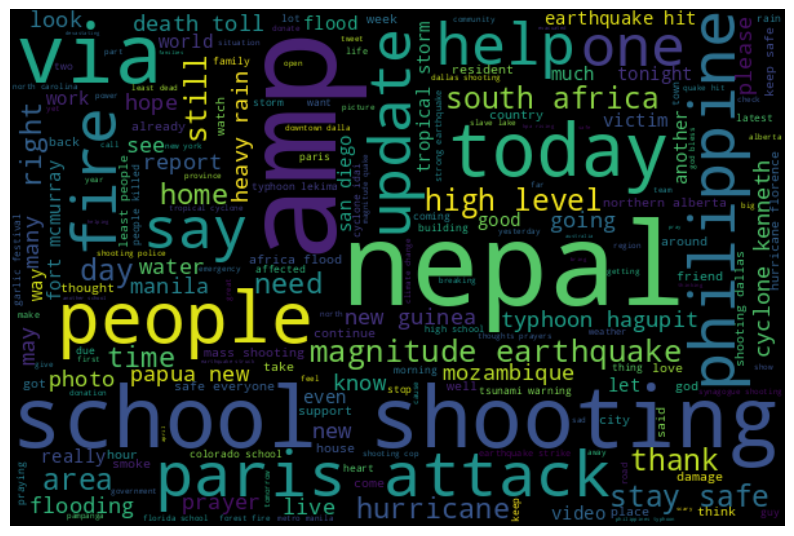

In [ ]:
# Word Cloud

# Import necessary word cloud packages and make settings
! pip install wordcloud
from wordcloud import WordCloud
%matplotlib inline

# Get all lemmitized words into one place
all_words_lem = ' '.join([word for word in df['tweet_lem']])

# Plot
wordcloud = WordCloud(width=600,
                     height=400,
                     random_state=2,
                     max_font_size=100).generate(all_words_lem)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

## Feature Extraction

In [ ]:
# Library estimates

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.tweet_clean).toarray()
labels = df.crisis_name_ID
features.shape

(40459, 14999)

In [ ]:
#  Transform tweet_text into vector of numbers.
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each tweet into a vector
# features = tfidf.fit_transform(df.tweet_clean).toarray()
# labels = df.event_id
# print("Each of the %d tweets is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))


In [ ]:
#category_to_id.items()

In [ ]:
# # Masks
# hurricane_mask = (df["disaster_type"] == "Hurricane")
# earthquake_mask = (df["disaster_type"] == "Earthquake")
# flood_mask = (df["disaster_type"] == "Floods")
# fire_mask = (df["disaster_type"] == "Fire")
# human_mask = (df["disaster_type"] == "Human Disaster")
# other_mask = (df["disaster_type"] == "Other")

# # Disaster type dataframes
# hurricane_df = pd.DataFrame(df[hurricane_mask])
# earthquake_df = pd.DataFrame(df[earthquake_mask])
# flood_df = pd.DataFrame(df[flood_mask])
# fire_df = pd.DataFrame(df[fire_mask])
# human_df = pd.DataFrame(df[human_mask])
# ohter_df = pd.DataFrame(df[other_mask])

##Functions:

###Compare Models
Function to compare which classification model performs best with our dataset

In [ ]:
# def compare_models (x_train, x_test, y_train, y_test):
#   classifiers = [RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
#                LinearSVC(), #this is a type of SVM
#                MultinomialNB()]#,
#                #LogisticRegression(max_iter = 110, random_state=0)] # Convergence issues
def compare_models (x_train, x_test, y_train, y_test):
  classifiers = [RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
               LinearSVC(), #this is a type of SVM
               MultinomialNB(),
                 LogisticRegression(multi_class='multinomial', max_iter = 110, random_state=0)]
               #LogisticRegression(max_iter = 110, random_state=0)] # Convergence issues

  for clf in classifiers:
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print('Classifier: {} \tAccuracy score: {}%'.format(clf.__class__.__name__,
                                                        accuracy_score(y_pred, y_test)))

###Test results
Function to get the results of Predicted & Actual (also known as what was already labeled)

In [ ]:
def test_results(y_test, y_pred):
  test_results = pd.DataFrame(y_test)
  test_results.rename(columns = {'inform_or_not_ID':'Actuals'}, inplace = True)
  test_results["Predicted"] = y_pred
  print(test_results)

#1) Classifying Informative or Not (inform_or_not):

###1.a) Imbalanced Dataset - Informative or Not

####1.a.1) Encode labels

In [ ]:
# Encode labels for informative and not_informative (2 labels)
# Informative = 0; not_informative = 1
df['inform_or_not_ID'] = df['not_informative'].factorize()[0]

df['inform_or_not_ID'].value_counts()

0    31458
1     9001
Name: inform_or_not_ID, dtype: int64

####1.a.2) Create X & Y Variables

In [ ]:
# Separate into data (X) and labels (y)
X_inform = df['tweet_lem'] # Collection of clean tweets
y_inform = df['not_informative'] # Target or the labels we want to predict

# TFIDF Settings; test and train set
tfidf = TfidfVectorizer(max_features=5000, analyzer='word', ngram_range=(1,2), stop_words='english')
X_train_inform = tfidf.fit_transform(X_inform).toarray()

x_train_inform, x_test_inform, y_train_inform, y_test_inform = train_test_split(X_train_inform, y_inform, test_size=0.2, random_state=0)

####1.a.3) Extract features using bag of words and tf-idf

In [ ]:
features_inform = tfidf.fit_transform(df.tweet_lem).toarray()
labels_inform = df.inform_or_not_ID
print(features_inform.shape)

print("Each of the 40459 tweets is represented by 5000 features, representing the tf-idf score for different unigrams and bigrams.")

(40459, 5000)
Each of the 40459 tweets is represented by 5000 features, representing the tf-idf score for different unigrams and bigrams.


####1.a.4) Select the Best Model


```
We will compare which models performed the best below
Models:
    1. Random Forest
    3. Linear SVC - type of SVM. Minimizes the squared hunge loss. LinearSVC uses one vs all multiclass reduction.
    4. MultinonialNB
    5. Logistic Regression
    6. BERT - still need to test BERT ***
```

In [ ]:
compare_models(x_train_inform, x_test_inform, y_train_inform, y_test_inform)

Classifier: RandomForestClassifier 	Accuracy score: 0.7804003954522986%
Classifier: LinearSVC 	Accuracy score: 0.8367523479980228%
Classifier: MultinomialNB 	Accuracy score: 0.8323035096391498%
Classifier: LogisticRegression 	Accuracy score: 0.8408304498269896%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


####1.a.5) Train w/ Best Model (Linear SVC)

In [ ]:
# SVC for Informative or Not
model = LinearSVC()
model.fit(x_train_inform, y_train_inform)
y_pred_inform = model.predict(x_test_inform)
accuracy_score(y_pred_inform, y_test_inform)

0.8367523479980228

In [ ]:
test_results(y_test_inform, y_pred_inform)

       not_informative  Predicted
32023                0          0
13104                0          0
29283                0          0
22320                0          0
28178                0          0
...                ...        ...
28788                0          0
6557                 0          0
654                  0          0
3491                 0          1
13556                0          1

[8092 rows x 2 columns]


In [ ]:
#For confusion matrix
category_id_df_inform = df[['not_informative', 'inform_or_not_ID']].drop_duplicates().sort_values('inform_or_not_ID')
category_to_id_inform = dict(category_id_df_inform.values)
id_to_category_inform = dict(category_id_df_inform[['inform_or_not_ID', 'not_informative']].values)

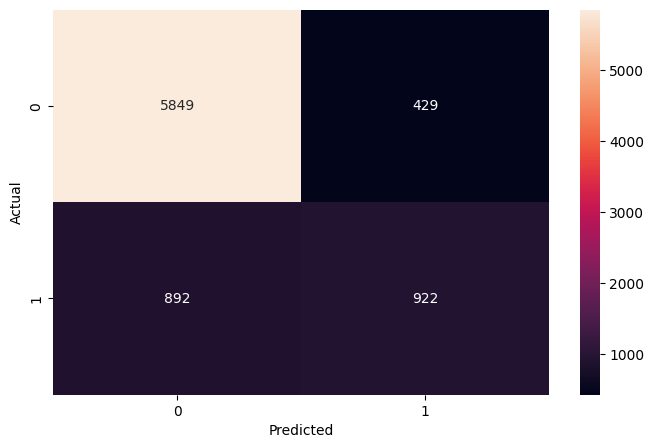

In [ ]:
#Confusion matrix

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_inform, y_pred_inform)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df_inform.inform_or_not_ID.values, yticklabels=category_id_df_inform.inform_or_not_ID.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
#Classification report
print('Classification Metrics:')
print()
print(metrics.classification_report(y_test_inform, y_pred_inform,
                                    target_names= df['inform_or_not_ID'].unique()))

Classification Metrics:



TypeError: ignored

###1.b) Balanced Dataset (ROS) - Informative or Not

In [ ]:
#oversample = RandomOverSampler(sampling_strategy=0.5)
ROS = RandomOverSampler(sampling_strategy='minority', random_state=None)

# fit and apply the transform
x_train_inform_random, y_train_inform_random = ROS.fit_resample(x_train_inform, y_train_inform)
x_train_inform_ROS, x_test_inform_ROS, y_train_inform_ROS, y_test_inform_ROS = train_test_split(x_train_inform_random, y_train_inform_random, test_size=0.2,random_state=42)

In [ ]:
compare_models(x_train_inform_ROS, x_test_inform_ROS, y_train_inform_ROS, y_test_inform_ROS)

Classifier: RandomForestClassifier 	Accuracy score: 0.7249801429706116%
Classifier: LinearSVC 	Accuracy score: 0.8194996028594123%
Classifier: MultinomialNB 	Accuracy score: 0.7834590945194599%
Classifier: LogisticRegression 	Accuracy score: 0.818109610802224%


In [ ]:
# Run LinearSVC model
model_inform_ROS = LinearSVC()
model_inform_ROS.fit(x_train_inform_ROS, y_train_inform_ROS)
y_pred_inform_ROS = model_inform_ROS.predict(x_test_inform_ROS)
accuracy_score(y_pred_inform_ROS, y_test_inform_ROS)

0.8194996028594123

In [ ]:
# Compare Labeled & Predicted
test_results(y_test_inform_ROS, y_pred_inform_ROS)

       not_informative  Predicted
32389                1          1
1570                 0          0
3366                 0          0
22698                1          1
33463                1          1
...                ...        ...
48432                1          1
49994                1          1
16050                1          1
48016                1          1
3547                 0          1

[10072 rows x 2 columns]


In [ ]:
# category_id_df_inform_ROS = df[['event_id', 'crisis_name_ID']].drop_duplicates().sort_values('crisis_name_ID')
# category_to_id_inform_ROS = dict(category_id_df_inform_ROS.values)
# id_to_category_inform_ROS = dict(category_id_df_inform_ROS[['crisis_name_ID', 'event_id']].values)

#For confusion matrix
category_id_df_inform_ROS = df[['not_informative', 'inform_or_not_ID']].drop_duplicates().sort_values('inform_or_not_ID')
category_to_id_inform_ROS = dict(category_id_df_inform.values)
id_to_category_inform_ROS = dict(category_id_df_inform[['inform_or_not_ID', 'not_informative']].values)

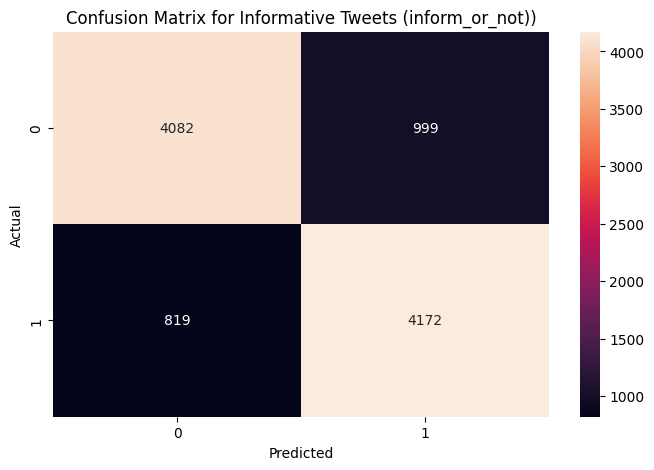

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test_inform_ROS, y_pred_inform_ROS)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df_inform.inform_or_not_ID.values, yticklabels=category_id_df_inform.inform_or_not_ID.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix for Informative Tweets (inform_or_not))")
plt.show()

In [ ]:
#Classification report
print('Classification Metrics for Disaster Event - Informative tweets:')
print()
print(metrics.classification_report(y_test_inform_ROS, y_pred_inform_ROS,
                                    target_names= df['inform_or_not_ID'].unique()))

Classification Metrics for Disaster Event - Informative tweets:



TypeError: ignored

#2) Create a new DF with only Informative Tweets:
    Since we are only interested in informative tweets, we need to create a new df that has only the predicted informative tweets.

In [ ]:
# Create new df with only informative tweets
informative_tweets = df[df['inform_or_not_ID'] == 0]
informative_tweets.head()

,event_id,post_id,text,categories,priority,timestamp,not_informative,tweet_clean,crisis_name_ID,disaster_type,tweet_token,text_string,tweet_fdist,tweet_lem,inform_or_not_ID
0,typhoonHagupit2014,541638434994266112,Photo: Prayers for the Philippines! #Hagupit h...,"Report-FirstPartyObservation,Report-Multimedia...",Low,2018-09-24 16:03:31+00:00,0,photo prayers for the philippines,0,Hurricane,"[photo, prayers, philippines]",photo prayers philippines,photo prayers philippines,photo prayers philippines,0
2,fireYMM2016,727137040362426368,Smoke has really thickened over #ymm in the pa...,"Report-MultimediaShare,Report-Hashtags",Low,2019-04-05 16:38:51+00:00,0,smoke has really thickened over in the past ho...,2,Fire,"[smoke, really, thickened, past, hour, still, ...",smoke really thickened past hour still big plu...,smoke really thickened past hour still big plu...,smoke really thickened past hour still big plu...,0
4,fireYMM2016,727577686437044224,Crews from Lesser Slave Lake department are he...,"Report-MultimediaShare,Report-Hashtags,Report-...",Low,2019-04-08 16:06:36+00:00,0,crews from lesser slave lake department are he...,2,Fire,"[crews, lesser, slave, lake, department, help,...",crews lesser slave lake department help local ...,crews lesser slave lake department help local ...,crews lesser slave lake department help local ...,0
5,shootingDallas2017,751245551644078080,Oh my Looky looky. #Trump supporters set Twitt...,"Report-Hashtags,Other-Sentiment",Low,2019-04-08 12:14:54+00:00,0,oh my looky looky supporters set twitter ablaz...,4,Human Disaster,"[oh, looky, looky, supporters, set, twitter, a...",looky looky supporters set twitter ablaze shoo...,looky looky supporters set twitter ablaze shoo...,looky looky supporters set twitter ablaze shoo...,0
7,hurricaneFlorence2018,1041118708557643776,25% of proceeds from 9/15 to 9/21 will go to t...,"Report-MultimediaShare,Other-Discussion",Low,2019-04-03 19:46:01+00:00,0,of proceeds from 15 to 21 will go to the caju...,1,Hurricane,"[proceeds, go, cajun, navy, help, folks, areas...",proceeds cajun navy help folks areas affected ...,proceeds cajun navy help folks areas affected ...,proceeds cajun navy help folks areas affected ...,0


In [ ]:
informative_tweets.shape

(31458, 15)

#3) Classify Disaster Event (event_id)

####3.a) Imbalanced Dataset - Disaster Event

In [ ]:
# Create X and y
X_event = informative_tweets['tweet_lem'] # Collection of tweets
y_event = informative_tweets['event_id'] # Target or the labels we want to predict

In [ ]:
# TFIDF Settings; test and train set
tfidf = TfidfVectorizer(max_features=5000, analyzer='word', ngram_range=(1,2), stop_words='english')
X_train_event = tfidf.fit_transform(X_event).toarray()

x_train_event, x_test_event, y_train_event, y_test_event = train_test_split(X_train_event, y_event, test_size=0.2, random_state=0)


In [ ]:
#Compare and find best classification model
compare_models(x_train_event, x_test_event, y_train_event, y_test_event)

Classifier: RandomForestClassifier 	Accuracy score: 0.3531468531468531%
Classifier: LinearSVC 	Accuracy score: 0.7999046408137317%
Classifier: MultinomialNB 	Accuracy score: 0.7226636999364272%
Classifier: LogisticRegression 	Accuracy score: 0.7840114431023522%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Run the best model (SVC) and get accuracy score for Disaster Event
model_event = LinearSVC()
model_event.fit(x_train_event, y_train_event)
y_pred_event = model_event.predict(x_test_event)
accuracy_score(y_pred_event, y_test_event)

0.7999046408137317

In [ ]:
test_results(y_test_event, y_pred_event)

                   event_id             Predicted
17228    typhoonHagupit2014    typhoonHagupit2014
3584     cycloneKenneth2019    cycloneKenneth2019
28490    bostonBombings2013    bostonBombings2013
3546    chileEarthquake2014   chileEarthquake2014
15407    typhoonHagupit2014   nepalEarthquake2015
...                     ...                   ...
4340    nepalEarthquake2015   nepalEarthquake2015
1430   albertaWildfires2019  albertaWildfires2019
926    queenslandFloods2013   nepalEarthquake2015
15347           fireYMM2016           fireYMM2016
23774    typhoonYolanda2013           fireYMM2016

[6292 rows x 2 columns]


In [ ]:
# For confusion matrix
# category_id_df = df[['event_id', 'crisis_name_ID']].drop_duplicates().sort_values('crisis_name_ID')
# category_to_id = dict(category_id_df.values)
# id_to_category = dict(category_id_df[['crisis_name_ID', 'event_id']].values)

category_id_df_event = informative_tweets[['event_id', 'crisis_name_ID']].drop_duplicates().sort_values('crisis_name_ID')
category_to_id_event = dict(category_id_df_event.values)
id_to_category_event = dict(category_id_df_event[['crisis_name_ID', 'event_id']].values)

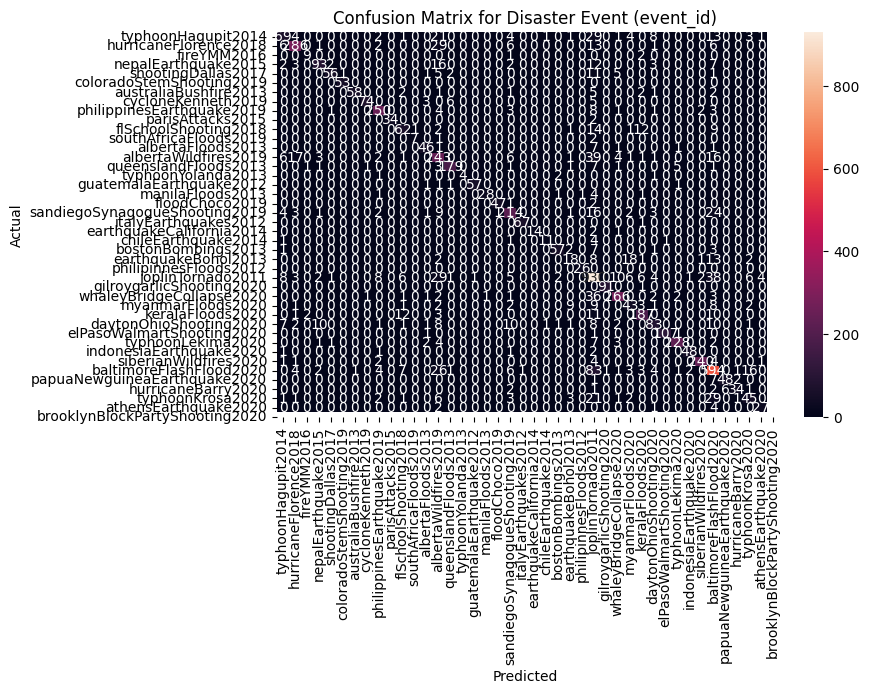

In [ ]:
# Confusion matrix
conf_mat = confusion_matrix(y_test_event, y_pred_event)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df_event.event_id.values, yticklabels=category_id_df_event.event_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix for Disaster Event (event_id)")
plt.show()

In [ ]:
# Classification report
print('Classification Metrics:')
print()
print(metrics.classification_report(y_test_event, y_pred_event,
                                    target_names= informative_tweets['event_id'].unique()))

Classification Metrics:



ValueError: ignored

In [ ]:
x = len(informative_tweets['event_id'].unique())
print(x)

42


In [ ]:
df_count = len(df['event_id'].unique())
print(df_count)

42


####3.b) Balanced Dataset (ROS) - Disaster Event

In [ ]:
ROS = RandomOverSampler(sampling_strategy='minority', random_state=None)

# fit and apply the transform
x_train_event_random, y_train_event_random = ROS.fit_resample(x_train_event, y_train_event)
x_train_event_ROS, x_test_event_ROS, y_train_event_ROS, y_test_event_ROS = train_test_split(x_train_event_random, y_train_event_random, test_size=0.2,random_state=42)

In [ ]:
#Compare and find best classification model
compare_models(x_train_event_ROS, x_test_event_ROS, y_train_event_ROS, y_test_event_ROS)

Classifier: RandomForestClassifier 	Accuracy score: 0.431791221826809%
Classifier: LinearSVC 	Accuracy score: 0.8366378579901712%
Classifier: MultinomialNB 	Accuracy score: 0.7495339772919845%
Classifier: LogisticRegression 	Accuracy score: 0.8118962887646162%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
model_event_ROS = LinearSVC()
model_event_ROS.fit(x_train_event_ROS, y_train_event_ROS)
y_pred_event_ROS = model_event_ROS.predict(x_test_event_ROS)
accuracy_score(y_pred_event_ROS, y_test_event_ROS)

0.8366378579901712

In [ ]:
test_results(y_test_event_ROS, y_pred_event_ROS)

                           event_id                     Predicted
3901           flSchoolShooting2018          flSchoolShooting2018
28578       baltimoreFlashFlood2020       baltimoreFlashFlood2020
21812          queenslandFloods2013          queenslandFloods2013
20649  papuaNewguineaEarthquake2020  papuaNewguineaEarthquake2020
9072            nepalEarthquake2015           nepalEarthquake2015
...                             ...                           ...
6145            nepalEarthquake2015           nepalEarthquake2015
23490            typhoonHagupit2014            typhoonHagupit2014
16026      coloradoStemShooting2019      coloradoStemShooting2019
11776              parisAttacks2015              parisAttacks2015
17799      coloradoStemShooting2019      coloradoStemShooting2019

[5901 rows x 2 columns]


In [ ]:
category_id_df_event_ROS = informative_tweets[['event_id', 'crisis_name_ID']].drop_duplicates().sort_values('crisis_name_ID')
category_to_id_event_ROS = dict(category_id_df_event_ROS.values)
id_to_category_event_ROS = dict(category_id_df_event_ROS[['crisis_name_ID', 'event_id']].values)

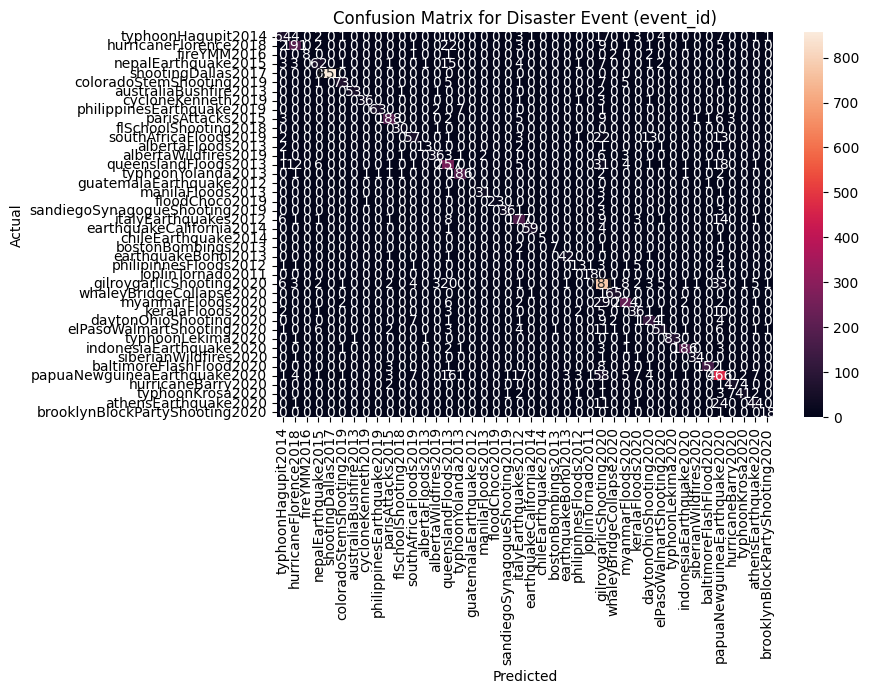

In [ ]:
conf_mat = confusion_matrix(y_test_event_ROS, y_pred_event_ROS)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df_event_ROS.event_id.values, yticklabels=category_id_df_event_ROS.event_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix for Disaster Event (event_id)")
plt.show()

In [ ]:
# Classification report
print('Classification Metrics for Disaster Event - Informative tweets:')
print()
print(metrics.classification_report(y_test_event_ROS, y_pred_event_ROS,
                                    target_names= informative_tweets['event_id'].unique()))

Classification Metrics for Disaster Event - Informative tweets:

                                precision    recall  f1-score   support

            typhoonHagupit2014       0.67      0.54      0.60       118
                   fireYMM2016       0.86      0.80      0.83       238
            shootingDallas2017       1.00      0.57      0.73        14
         hurricaneFlorence2018       0.74      0.61      0.67       101
           nepalEarthquake2015       1.00      1.00      1.00       857
         australiaBushfire2013       0.91      0.78      0.84        93
              parisAttacks2015       0.98      0.93      0.95        57
          flSchoolShooting2018       0.95      0.86      0.90        42
         southAfricaFloods2019       0.98      0.86      0.92        73
             albertaFloods2013       0.92      0.86      0.89       218
          albertaWildfires2019       0.91      0.97      0.94        31
      coloradoStemShooting2019       0.72      0.51      0.60       11

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#4) Classify Disaster Type (disaster_type)

####4.a) Imbalanced Dataset - Disaster Type

In [ ]:
# Data and labels to analyze
#df['disaster_type_ID'] = df['disaster_type'].factorize()[0]
informative_tweets['disaster_type_ID'] = informative_tweets['disaster_type'].factorize()[0]

# Create X and y
X_disas_type = informative_tweets['tweet_lem'] # Collection of tweets
y_disas_type = informative_tweets['disaster_type'] # Target or the labels we want to predict

<ipython-input-85-2718f90ef7a3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_tweets['disaster_type_ID'] = informative_tweets['disaster_type'].factorize()[0]


In [ ]:
# TFIDF Settings; test and train set

tfidf = TfidfVectorizer(max_features=5000, analyzer='word', ngram_range=(1,2), stop_words='english')
X_train_disas_type = tfidf.fit_transform(X_disas_type).toarray()

x_train_disas_type, x_test_disas_type, y_train_disas_type, y_test_disas_type = train_test_split(X_train_disas_type, y_disas_type, test_size=0.2, random_state=0)

In [ ]:
#Compare and find best classification model
compare_models(x_train_disas_type, x_test_disas_type, y_train_disas_type, y_test_disas_type)

Classifier: RandomForestClassifier 	Accuracy score: 0.6193579148124603%
Classifier: LinearSVC 	Accuracy score: 0.8641131595677051%
Classifier: MultinomialNB 	Accuracy score: 0.8480610298792117%
Classifier: LogisticRegression 	Accuracy score: 0.8622059758423395%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# SVC
model_disas_type = LinearSVC()
model_disas_type.fit(x_train_disas_type, y_train_disas_type)
y_pred_disas_type = model_disas_type.predict(x_test_disas_type)
accuracy_score(y_pred_disas_type, y_test_disas_type)

0.8641131595677051

In [ ]:
# Confusion matrix labels and parameters
#features2 = tfidf.fit_transform(df3.tweet_lem).toarray()
#features = tfidf.fit_transform(informative_tweets.tweet_lem).toarray()
features_disas_type = X_train_disas_type #X_train has already been done so no need to do it again
labels_disas_type = informative_tweets.disaster_type
# diaster id
disaster_id_df_disas_type = informative_tweets[['disaster_type', 'disaster_type_ID']].drop_duplicates().sort_values('disaster_type_ID')

In [ ]:
category_id_df_disas_type = informative_tweets[['disaster_type', 'disaster_type_ID']].drop_duplicates().sort_values('disaster_type_ID')
category_to_id_disas_type = dict(category_id_df_disas_type.values)
id_to_category_disas_type = dict(category_id_df_disas_type[['disaster_type_ID', 'disaster_type']].values)

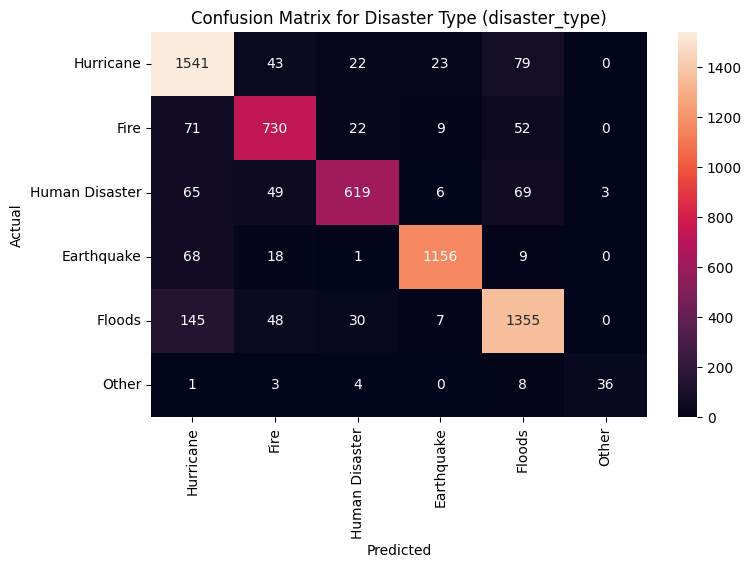

In [ ]:
conf_mat = confusion_matrix(y_test_disas_type, y_pred_disas_type)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df_disas_type.disaster_type.values, yticklabels=category_id_df_disas_type.disaster_type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix for Disaster Type (disaster_type)")
plt.show()

In [ ]:
# Classification report
print('Classification Metrics for Disaster Type - Informative Tweets:')
print()
print(metrics.classification_report(y_test_disas_type, y_pred_disas_type,
                                    target_names= informative_tweets['disaster_type'].unique()))

Classification Metrics for Disaster Type - Informative Tweets:

                precision    recall  f1-score   support

     Hurricane       0.81      0.90      0.86      1708
          Fire       0.82      0.83      0.82       884
Human Disaster       0.89      0.76      0.82       811
    Earthquake       0.96      0.92      0.94      1252
        Floods       0.86      0.85      0.86      1585
         Other       0.92      0.69      0.79        52

      accuracy                           0.86      6292
     macro avg       0.88      0.83      0.85      6292
  weighted avg       0.87      0.86      0.86      6292



####4.b) Balanced Dataset (ROS)

In [ ]:
ROS = RandomOverSampler(sampling_strategy='minority', random_state=None)

# fit and apply the transform
#x_train_event_ROS, y_train_event_ROS = ROS.fit_resample(vectorized_df_event, y_train_event)
x_train_disas_type_random, y_train_disas_type_random = ROS.fit_resample(x_train_disas_type, y_train_disas_type)
x_train_disas_type_ROS, x_test_disas_type_ROS, y_train_disas_type_ROS, y_test_disas_type_ROS = train_test_split(x_train_disas_type_random, y_train_disas_type_random, test_size=0.2,random_state=42)

In [ ]:
#Compare and find best classification model
compare_models(x_train_disas_type_ROS, x_test_disas_type_ROS, y_train_disas_type_ROS, y_test_disas_type_ROS)

Classifier: RandomForestClassifier 	Accuracy score: 0.654651345820872%
Classifier: LinearSVC 	Accuracy score: 0.8962694789863057%
Classifier: MultinomialNB 	Accuracy score: 0.8805288839918148%
Classifier: LogisticRegression 	Accuracy score: 0.8965842908861955%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
model_disas_type_ROS = LinearSVC()
model_disas_type_ROS.fit(x_train_disas_type_ROS, y_train_disas_type_ROS)
y_pred_disas_type_ROS = model_disas_type_ROS.predict(x_test_disas_type_ROS)
accuracy_score(y_pred_disas_type_ROS, y_test_disas_type_ROS)

0.8962694789863057

In [ ]:
test_results(y_test_disas_type_ROS, y_pred_disas_type_ROS)

        disaster_type       Predicted
15095  Human Disaster  Human Disaster
13212      Earthquake      Earthquake
24387      Earthquake      Earthquake
14145            Fire            Fire
5005           Floods          Floods
...               ...             ...
31087           Other           Other
15013  Human Disaster  Human Disaster
20174            Fire            Fire
14943       Hurricane            Fire
2546       Earthquake       Hurricane

[6353 rows x 2 columns]


In [ ]:
category_id_df_disas_type_ROS = informative_tweets[['disaster_type', 'disaster_type_ID']].drop_duplicates().sort_values('disaster_type_ID')
category_to_id_disas_type_ROS = dict(category_id_df_disas_type_ROS.values)
id_to_category_disas_type_ROS = dict(category_id_df_disas_type_ROS[['disaster_type_ID', 'disaster_type']].values)

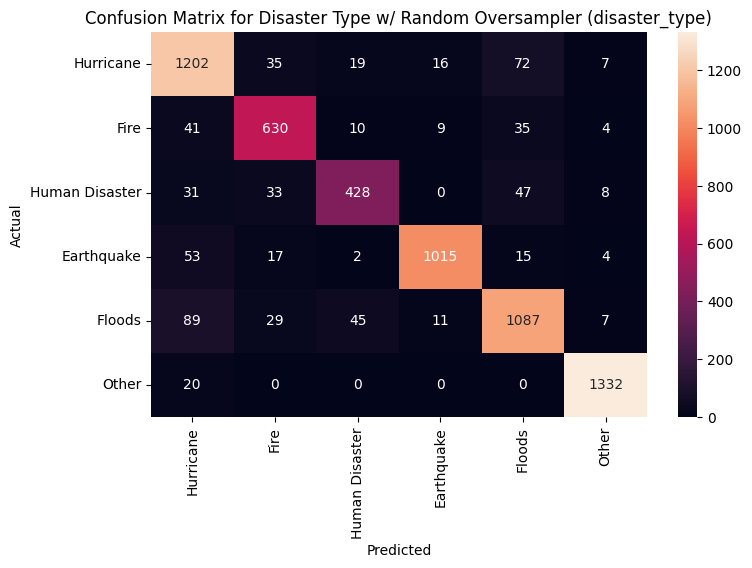

In [ ]:
conf_mat = confusion_matrix(y_test_disas_type_ROS, y_pred_disas_type_ROS)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df_disas_type_ROS.disaster_type.values, yticklabels=category_id_df_disas_type_ROS.disaster_type.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix for Disaster Type w/ Random Oversampler (disaster_type)")
plt.show()

In [ ]:
# Classification report
print('Classification Metrics:')
print(metrics.classification_report(y_test_disas_type_ROS, y_pred_disas_type_ROS,
                                    target_names= df['disaster_type'].unique()))

Classification Metrics:
                precision    recall  f1-score   support

     Hurricane       0.83      0.89      0.86      1351
          Fire       0.85      0.86      0.86       729
    Earthquake       0.85      0.78      0.81       547
Human Disaster       0.97      0.92      0.94      1106
        Floods       0.87      0.86      0.86      1268
         Other       0.98      0.98      0.98      1352

      accuracy                           0.90      6353
     macro avg       0.89      0.88      0.89      6353
  weighted avg       0.90      0.90      0.90      6353



#5) Classify Priority Level (priority):

###5.a) Imbalanced Dataset - Priority Level

In [ ]:
# Check disaster labels to match disaster types:
informative_tweets.priority.value_counts()

Low         21253
Medium       5933
High         3823
Critical      449
Name: priority, dtype: int64

In [ ]:
# Set up priority id for analysis
informative_tweets['priority_ID'] = informative_tweets['priority'].factorize()[0]
informative_tweets.priority.value_counts()

#0 - Low
#1 - Medium
#2 - High
#3 - Critical

<ipython-input-99-53989f95d099>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_tweets['priority_ID'] = informative_tweets['priority'].factorize()[0]


Low         21253
Medium       5933
High         3823
Critical      449
Name: priority, dtype: int64

In [ ]:
# Set up X and y variables for analysis
X_priority = informative_tweets['tweet_lem'] # Collection of tweets
y_priority = informative_tweets['priority'] # Target or the labels we want to predict

In [ ]:
# TFIDF Settings; test and train set
tfidf = TfidfVectorizer(max_features=5000, analyzer='word', ngram_range=(1,2), stop_words='english')
X_train_priority = tfidf.fit_transform(X_priority).toarray()

x_train_priority, x_test_priority, y_train_priority, y_test_priority = train_test_split(X_train_priority, y_priority, test_size=0.2, random_state=0)

In [ ]:
# Compare and find best classification model
compare_models(x_train_priority, x_test_priority, y_train_priority, y_test_priority)

Classifier: RandomForestClassifier 	Accuracy score: 0.677050222504768%
Classifier: LinearSVC 	Accuracy score: 0.7128099173553719%
Classifier: MultinomialNB 	Accuracy score: 0.715034965034965%
Classifier: LogisticRegression 	Accuracy score: 0.7267959313413859%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Run LinearSVC model
model_priority = LinearSVC()
model_priority.fit(x_train_priority, y_train_priority)
y_pred_priority = model_priority.predict(x_test_priority)
accuracy_score(y_pred_priority, y_test_priority)

0.7128099173553719

In [ ]:
test_results(y_test_priority, y_pred_priority)

      priority Predicted
17228      Low       Low
3584       Low       Low
28490      Low       Low
3546       Low       Low
15407      Low       Low
...        ...       ...
4340      High       Low
1430       Low       Low
926     Medium    Medium
15347      Low       Low
23774      Low       Low

[6292 rows x 2 columns]


In [ ]:
category_id_df_priority = informative_tweets[['priority', 'priority_ID']].drop_duplicates().sort_values('priority_ID')
category_to_id_priority = dict(category_id_df_priority.values)
id_to_category_priority = dict(category_id_df_priority[['priority_ID', 'priority']].values)

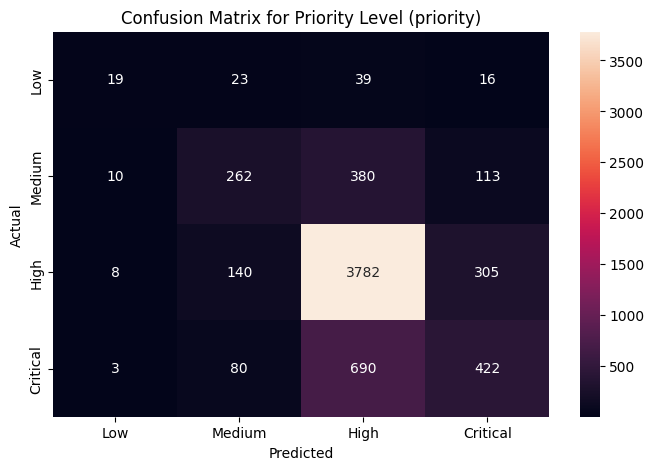

In [ ]:
conf_mat = confusion_matrix(y_test_priority, y_pred_priority)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df_priority.priority.values, yticklabels=category_id_df_priority.priority.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix for Priority Level (priority)")
plt.show()

In [ ]:
# Classification report
print('Classification Metrics for Priority Level:')
print()
print(metrics.classification_report(y_test_priority, y_pred_priority,
                                    target_names= informative_tweets['priority'].unique()))

Classification Metrics for Priority Level:

              precision    recall  f1-score   support

         Low       0.47      0.20      0.28        97
      Medium       0.52      0.34      0.41       765
        High       0.77      0.89      0.83      4235
    Critical       0.49      0.35      0.41      1195

    accuracy                           0.71      6292
   macro avg       0.57      0.45      0.48      6292
weighted avg       0.68      0.71      0.69      6292



###5.b) Balanced Dataset (ROS)

In [ ]:
# Oversample using randomoversampler
ROS = RandomOverSampler(sampling_strategy='minority', random_state=None)

# fit and apply the transform
#x_train_event_ROS, y_train_event_ROS = ROS.fit_resample(vectorized_df_event, y_train_event)
x_train_priority_random, y_train_priority_random = ROS.fit_resample(x_train_priority, y_train_priority)
x_train_priority_ROS, x_test_priority_ROS, y_train_priority_ROS, y_test_priority_ROS = train_test_split(x_train_priority_random, y_train_priority_random, test_size=0.2,random_state=42)

In [ ]:
# Compare and find best classification model
compare_models(x_train_priority_ROS, x_test_priority_ROS, y_train_priority_ROS, y_test_priority_ROS)

Classifier: RandomForestClassifier 	Accuracy score: 0.6222062866021274%
Classifier: LinearSVC 	Accuracy score: 0.8213218596868651%
Classifier: MultinomialNB 	Accuracy score: 0.7989721525038843%
Classifier: LogisticRegression 	Accuracy score: 0.8264610971674435%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
model_priority_ROS = LinearSVC()
model_priority_ROS.fit(x_train_priority_ROS, y_train_priority_ROS)
y_pred_priority_ROS = model_priority_ROS.predict(x_test_priority_ROS)
accuracy_score(y_pred_priority_ROS, y_test_priority_ROS)

0.8213218596868651

In [ ]:
test_results(y_test_priority_ROS, y_pred_priority_ROS)

       priority Predicted
1570        Low       Low
10413       Low       Low
9693     Medium    Medium
16181       Low       Low
36905  Critical  Critical
...         ...       ...
23844       Low       Low
29885  Critical  Critical
30308  Critical  Critical
16548    Medium    Medium
8648       High      High

[8367 rows x 2 columns]


In [ ]:
test_results_priority_ROS = pd.DataFrame(y_test_priority_ROS)
test_results_priority_ROS.rename(columns = {'priority':'Actual'}, inplace = True)
test_results_priority_ROS["Predicted"] = y_pred_priority_ROS
test_results_priority_ROS

,Actual,Predicted
1570,Low,Low
10413,Low,Low
9693,Medium,Medium
16181,Low,Low
36905,Critical,Critical
...,...,...
23844,Low,Low
29885,Critical,Critical
30308,Critical,Critical
16548,Medium,Medium


In [ ]:
category_id_df_priority_ROS = informative_tweets[['priority', 'priority_ID']].drop_duplicates().sort_values('priority_ID')
category_to_id_priority_ROS = dict(category_id_df_priority_ROS.values)
id_to_category_priority_ROS = dict(category_id_df_priority_ROS[['priority_ID', 'priority']].values)

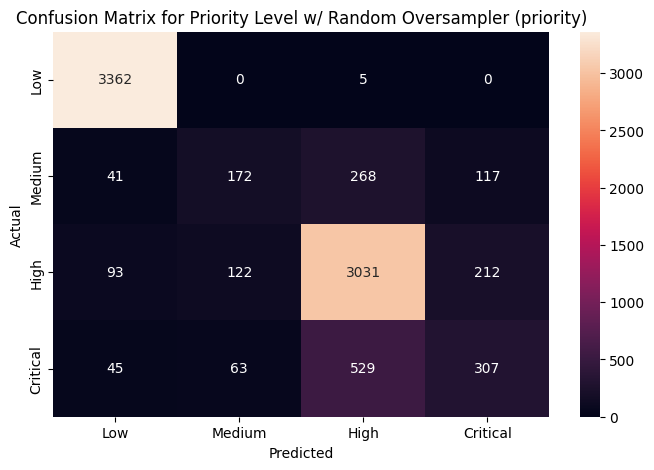

In [ ]:
conf_mat = confusion_matrix(y_test_priority_ROS, y_pred_priority_ROS)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df_priority_ROS.priority.values, yticklabels=category_id_df_priority_ROS.priority.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix for Priority Level w/ Random Oversampler (priority)")
plt.show()

In [ ]:
# Classification report
print('Classification Metrics:')
print(metrics.classification_report(y_test_priority_ROS, y_pred_priority_ROS,
                                    target_names= informative_tweets['priority'].unique()))

Classification Metrics:
              precision    recall  f1-score   support

         Low       0.95      1.00      0.97      3367
      Medium       0.48      0.29      0.36       598
        High       0.79      0.88      0.83      3458
    Critical       0.48      0.33      0.39       944

    accuracy                           0.82      8367
   macro avg       0.68      0.62      0.64      8367
weighted avg       0.80      0.82      0.80      8367



# 6) Multilabel Classification for Information Type (Categories):
    6.1) We begin by applying binary relevance with a classifier chain to our original dataset
    6.2) We then drop labels that are less useful to our disaster detection needs to see if it improves the accuracy and hamming loss.
    6.3) The third experiment involved combining the minority classes into one to see if it improves scores and is a more balanced dataset.

In [ ]:
taskCategories = [
    "CallToAction-Donations",
    "CallToAction-MovePeople",
    "CallToAction-Volunteer",
    "Other-Advice",
    "Other-ContextualInformation",
    "Other-Discussion",
    "Other-Irrelevant",
    "Other-Sentiment",
    "Report-CleanUp",
    "Report-EmergingThreats",
    "Report-Factoid",
    "Report-FirstPartyObservation",
    "Report-Hashtags",
    "Report-Location",
    "Report-MultimediaShare",
    "Report-News",
    "Report-NewSubEvent",
    "Report-Official",
    "Report-OriginalEvent",
    "Report-ServiceAvailable",
    "Report-ThirdPartyObservation",
    "Report-Weather",
    "Request-GoodsServices",
    "Request-InformationWanted",
    "Request-SearchAndRescue"]

In [ ]:
# Original from Nathan
# Action
informative_tweets['Donations'] = informative_tweets['categories'].str.contains(taskCategories[0]).astype(int)
informative_tweets['MovePeople'] = informative_tweets['categories'].str.contains(taskCategories[1]).astype(int)
informative_tweets['Volunteer'] = informative_tweets['categories'].str.contains(taskCategories[2]).astype(int)
# Other
informative_tweets['Advice'] = informative_tweets['categories'].str.contains(taskCategories[3]).astype(int)
informative_tweets['ContextualInformation'] = informative_tweets['categories'].str.contains(taskCategories[4]).astype(int)
informative_tweets['Discussion'] = informative_tweets['categories'].str.contains(taskCategories[5]).astype(int)
informative_tweets['Irrelevant'] = informative_tweets['categories'].str.contains(taskCategories[6]).astype(int)
informative_tweets['Sentiment'] = informative_tweets['categories'].str.contains(taskCategories[7]).astype(int)
# Report
informative_tweets['CleanUp'] = informative_tweets['categories'].str.contains(taskCategories[8]).astype(int)
informative_tweets['EmergingThreats'] = informative_tweets['categories'].str.contains(taskCategories[9]).astype(int)
informative_tweets['Factoid'] = informative_tweets['categories'].str.contains(taskCategories[10]).astype(int)
informative_tweets['FirstPartyObservation'] = informative_tweets['categories'].str.contains(taskCategories[11]).astype(int)
informative_tweets['Hashtags'] = informative_tweets['categories'].str.contains(taskCategories[12]).astype(int)
informative_tweets['Location'] = informative_tweets['categories'].str.contains(taskCategories[13]).astype(int)
informative_tweets['MultimediaShare'] = informative_tweets['categories'].str.contains(taskCategories[14]).astype(int)
informative_tweets['News'] = informative_tweets['categories'].str.contains(taskCategories[15]).astype(int)
informative_tweets['NewSubEvent'] = informative_tweets['categories'].str.contains(taskCategories[16]).astype(int)
informative_tweets['Official'] = informative_tweets['categories'].str.contains(taskCategories[17]).astype(int)
informative_tweets['OriginalEvent'] = informative_tweets['categories'].str.contains(taskCategories[18]).astype(int)
informative_tweets['ServiceAvailable'] = informative_tweets['categories'].str.contains(taskCategories[19]).astype(int)
informative_tweets['ThirdPartyObservation'] = informative_tweets['categories'].str.contains(taskCategories[20]).astype(int)
informative_tweets['Weather'] = informative_tweets['categories'].str.contains(taskCategories[21]).astype(int)
# Request
informative_tweets['GoodsServices'] = informative_tweets['categories'].str.contains(taskCategories[22]).astype(int)
informative_tweets['InformationWanted'] = informative_tweets['categories'].str.contains(taskCategories[23]).astype(int)
informative_tweets['SearchAndRescue'] = informative_tweets['categories'].str.contains(taskCategories[24]).astype(int)

<ipython-input-52-f787ed1bcad3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_tweets['Donations'] = informative_tweets['categories'].str.contains(taskCategories[0]).astype(int)
<ipython-input-52-f787ed1bcad3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_tweets['MovePeople'] = informative_tweets['categories'].str.contains(taskCategories[1]).astype(int)
<ipython-input-52-f787ed1bcad3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [ ]:
CallToAction = ["Donations", "MovePeople", "Volunteer"]
Other = ["Advice", "ContextualInformation", "Discussion", "Irrelevant", "Sentiment"]
Report1 = ["CleanUp", "Factoid", "FirstPartyObservation", "Hashtags", "Location",
          "MultimediaShare", "News", "NewSubEvent", "ThirdPartyObservation"]

Report2 = ["EmergingThreats", "Official", "OriginalEvent", "ServiceAvailable", "Weather"]

Request = ["GoodsServices", "InformationWanted", "SearchAndRescue"]

In [ ]:
# Set up model parameters for x variables
X = informative_tweets['tweet_lem'] # Collection of tweets
tfidf = TfidfVectorizer()
Xfeatures = tfidf.fit_transform(X).toarray()

In [ ]:
#TO DO - also include precision and F1 score in the model***
def build_model(model,mlb_estimator,xtrain,ytrain,xtest,ytest):
    clf = mlb_estimator(model)
    clf.fit(xtrain,ytrain)
    clf_predictions = clf.predict(xtest)
    acc = accuracy_score(ytest,clf_predictions)
    ham = hamming_loss(ytest,clf_predictions)
    result = {"accuracy:":acc,"hamming_score":ham}
    return result

###6.1) Imbalanced Dataset (original)

####CallToAction

In [ ]:
y_original = informative_tweets[CallToAction]

In [ ]:
# Test and train - Too much RAM (system crashed)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(Xfeatures, y_original, test_size=0.2, random_state=42)

In [ ]:
# Convert multi-label problem to a multi-class problem
binary_rel_clf = BinaryRelevance(MultinomialNB()) # Naive Bayes algorithm method used for classification

In [ ]:
# We fit the model into the dataset to recognize patterns from the dataset
binary_rel_clf.fit(X_train_orig,y_train_orig)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
#We test our model using the test data. We see if the model can make a prediction using the test data.
br_prediction = binary_rel_clf.predict(X_test_orig)
br_prediction.toarray()

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [ ]:
clf_chain_model = build_model(MultinomialNB(),ClassifierChain,X_train_orig,y_train_orig,X_test_orig,y_test_orig)
clf_chain_model

{'accuracy:': 0.9593134138588684, 'hamming_score': 0.014038991311718584}

####Other

In [ ]:
y_other_original = informative_tweets[Other]

In [ ]:
# Test and train - Too much RAM (system crashed)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(Xfeatures, y_other_original, test_size=0.2, random_state=42)

In [ ]:
# Convert multi-label problem to a multi-class problem
binary_rel_clf = BinaryRelevance(MultinomialNB())

# We fit the model into the dataset to recognize patterns from the dataset
binary_rel_clf.fit(X_train_orig,y_train_orig)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
#We test our model using the test data. We see if the model can make a prediction using the test data.
br_prediction = binary_rel_clf.predict(X_test_orig)
br_prediction.toarray()

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [ ]:
clf_chain_model = build_model(MultinomialNB(),ClassifierChain,X_train_orig,y_train_orig,X_test_orig,y_test_orig)
clf_chain_model

{'accuracy:': 0.6427209154481882, 'hamming_score': 0.09005085823267642}

####Report1

In [ ]:
y_rep1_original = informative_tweets[Report1]

In [ ]:
# Test and train - Too much RAM (system crashed)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(Xfeatures, y_rep1_original, test_size=0.2, random_state=42)

In [ ]:
# Convert multi-label problem to a multi-class problem
binary_rel_clf = BinaryRelevance(MultinomialNB())

# We fit the model into the dataset to recognize patterns from the dataset
binary_rel_clf.fit(X_train_orig,y_train_orig)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
#We test our model using the test data. We see if the model can make a prediction using the test data.
br_prediction = binary_rel_clf.predict(X_test_orig)
br_prediction.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [ ]:
clf_chain_model = build_model(MultinomialNB(),ClassifierChain,X_train_orig,y_train_orig,X_test_orig,y_test_orig)
clf_chain_model

{'accuracy:': 0.24570883661792753, 'hamming_score': 0.15794306703397612}

####Report2

In [ ]:
y_rep2_original = informative_tweets[Report2]

In [ ]:
# Test and train - Too much RAM (system crashed)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(Xfeatures, y_rep2_original, test_size=0.2, random_state=42)

In [ ]:
# Convert multi-label problem to a multi-class problem
binary_rel_clf = BinaryRelevance(MultinomialNB())

# We fit the model into the dataset to recognize patterns from the dataset
binary_rel_clf.fit(X_train_orig,y_train_orig)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
#We test our model using the test data. We see if the model can make a prediction using the test data.
br_prediction = binary_rel_clf.predict(X_test_orig)
br_prediction.toarray()

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
clf_chain_model = build_model(MultinomialNB(),ClassifierChain,X_train_orig,y_train_orig,X_test_orig,y_test_orig)
clf_chain_model

{'accuracy:': 0.6981881754609027, 'hamming_score': 0.07031150667514303}

####Request

In [ ]:
y_req_original = informative_tweets[Request]

In [ ]:
# Test and train - Too much RAM (system crashed)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(Xfeatures, y_req_original, test_size=0.2, random_state=42)

In [ ]:
# Convert multi-label problem to a multi-class problem
binary_rel_clf = BinaryRelevance(MultinomialNB())

# We fit the model into the dataset to recognize patterns from the dataset
binary_rel_clf.fit(X_train_orig,y_train_orig)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
#We test our model using the test data. We see if the model can make a prediction using the test data.
br_prediction = binary_rel_clf.predict(X_test_orig)
br_prediction.toarray()

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [ ]:
clf_chain_model = build_model(MultinomialNB(),ClassifierChain,X_train_orig,y_train_orig,X_test_orig,y_test_orig)
clf_chain_model

{'accuracy:': 0.981404958677686, 'hamming_score': 0.006516211061665607}

### 6.2) Dropped unuseful labels



In [ ]:
# removed Advice, Irrelevant, Sentiment, Factoid
taskCategories = [
    "CallToAction-Donations",#0
    "CallToAction-MovePeople",#1
    "CallToAction-Volunteer",#2
    "Other-ContextualInformation",#3
    "Other-Discussion",#4
    "Report-CleanUp",#5
    "Report-EmergingThreats",#6
    "Report-FirstPartyObservation",#7
    "Report-Hashtags",#8
    "Report-Location",#9
    "Report-MultimediaShare",#10
    "Report-News",#11
    "Report-NewSubEvent",#12
    "Report-Official",#13
    "Report-OriginalEvent",#14
    "Report-ServiceAvailable",#15
    "Report-ThirdPartyObservation",#16
    "Report-Weather",#17
    "Request-GoodsServices",#18
    "Request-InformationWanted",#29
    "Request-SearchAndRescue",#20
]

In [ ]:
# Action
informative_tweets['Donations'] = informative_tweets['categories'].str.contains(taskCategories[0]).astype(int)
informative_tweets['MovePeople'] = informative_tweets['categories'].str.contains(taskCategories[1]).astype(int)
informative_tweets['Volunteer'] = informative_tweets['categories'].str.contains(taskCategories[2]).astype(int)
# Other
informative_tweets['ContextualInformation'] = informative_tweets['categories'].str.contains(taskCategories[3]).astype(int)
informative_tweets['Discussion'] = informative_tweets['categories'].str.contains(taskCategories[4]).astype(int)
# Report
informative_tweets['CleanUp'] = informative_tweets['categories'].str.contains(taskCategories[5]).astype(int)
informative_tweets['EmergingThreats'] = informative_tweets['categories'].str.contains(taskCategories[6]).astype(int)
informative_tweets['FirstPartyObservation'] = informative_tweets['categories'].str.contains(taskCategories[7]).astype(int)
informative_tweets['Hashtags'] = informative_tweets['categories'].str.contains(taskCategories[8]).astype(int)
informative_tweets['Location'] = informative_tweets['categories'].str.contains(taskCategories[9]).astype(int)
informative_tweets['MultimediaShare'] = informative_tweets['categories'].str.contains(taskCategories[10]).astype(int)
informative_tweets['News'] = informative_tweets['categories'].str.contains(taskCategories[11]).astype(int)
informative_tweets['NewSubEvent'] = informative_tweets['categories'].str.contains(taskCategories[12]).astype(int)
informative_tweets['Official'] = informative_tweets['categories'].str.contains(taskCategories[13]).astype(int)
informative_tweets['OriginalEvent'] = informative_tweets['categories'].str.contains(taskCategories[14]).astype(int)
informative_tweets['ServiceAvailable'] = informative_tweets['categories'].str.contains(taskCategories[15]).astype(int)
informative_tweets['ThirdPartyObservation'] = informative_tweets['categories'].str.contains(taskCategories[16]).astype(int)
informative_tweets['Weather'] = informative_tweets['categories'].str.contains(taskCategories[17]).astype(int)
# Request
informative_tweets['GoodsServices'] = informative_tweets['categories'].str.contains(taskCategories[18]).astype(int)
informative_tweets['InformationWanted'] = informative_tweets['categories'].str.contains(taskCategories[19]).astype(int)
informative_tweets['SearchAndRescue'] = informative_tweets['categories'].str.contains(taskCategories[20]).astype(int)

<ipython-input-90-d2722ab66090>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_tweets['Donations'] = informative_tweets['categories'].str.contains(taskCategories[0]).astype(int)
<ipython-input-90-d2722ab66090>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_tweets['MovePeople'] = informative_tweets['categories'].str.contains(taskCategories[1]).astype(int)
<ipython-input-90-d2722ab66090>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [ ]:
## Removed less useful labels:
# Other - Advice, Irrelevant, Sentiment
# Report - Factoid

CallToAction = ["Donations", "MovePeople", "Volunteer"]

#Other = ["Advice", "ContextualInformation", "Discussion", "Irrelevant", "Sentiment"]
Other = ["ContextualInformation", "Discussion"]

#news & observations
# Report1 = ["CleanUp", "Factoid", "FirstPartyObservation", "Hashtags", "Location",
#           "MultimediaShare", "News", "NewSubEvent", "ThirdPartyObservation"]

#real experience
# Report2 = ["EmergingThreats", "Official", "OriginalEvent", "ServiceAvailable", "Weather"]

Report = ["CleanUp", "FirstPartyObservation", "Hashtags", "Location",
          "MultimediaShare", "News", "NewSubEvent", "ThirdPartyObservation",
          "EmergingThreats", "Official", "OriginalEvent", "ServiceAvailable", "Weather"]

Request = ["GoodsServices", "InformationWanted", "SearchAndRescue"]
# Request = ["SearchAndRescue"]

# I CAN REMOVE THE LABELS THAT AREN'T AS USEFUL**

####CallToAction

<BarContainer object of 3 artists>

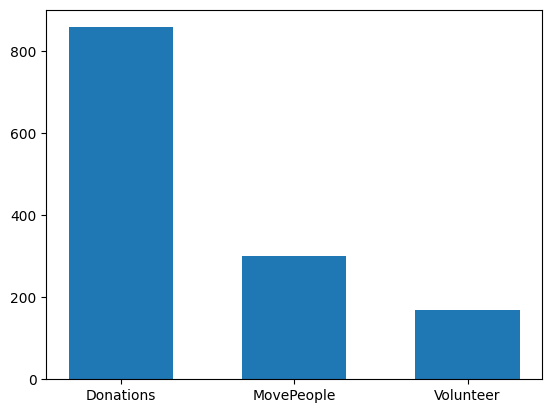

In [ ]:
# Visualize w/ bar graph
CallToAction_count = [informative_tweets.Donations.sum(), informative_tweets.MovePeople.sum(),
         informative_tweets.Volunteer.sum()]

plt.bar(CallToAction, CallToAction_count, width=0.6)

In [ ]:
y_unuseful = informative_tweets[CallToAction]

In [ ]:
# Test and train - Too much RAM (system crashed)
X_train_uns, X_test_uns, y_train_uns, y_test_uns = train_test_split(Xfeatures, y_unuseful, test_size=0.2, random_state=42)

In [ ]:
# Convert multi-label problem to a multi-class problem
binary_rel_clf = BinaryRelevance(MultinomialNB()) # Naive Bayes algorithm method used for classification

In [ ]:
# We fit the model into the dataset to recognize patterns from the dataset
binary_rel_clf.fit(X_train_uns,y_train_uns)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
#We test our model using the test data. We see if the model can make a prediction using the test data.
br_prediction = binary_rel_clf.predict(X_test_uns)
br_prediction.toarray()

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [ ]:
clf_chain_model = build_model(MultinomialNB(),ClassifierChain,X_train_uns,y_train_uns,X_test_uns,y_test_uns)
clf_chain_model

{'accuracy:': 0.9593134138588684, 'hamming_score': 0.014038991311718584}

Hamming loss is the fraction of labels that are incorrectly predicted. We have a hamming loss of 1.40% expressed as a percentage in the output above. This shows that only 1.40% of the predictions were wrong out of all the predictions.

This percentage is low and shows that our model was well trained. Continuous training will reduce this percentage, making the model more accurate.

#### 6.1.c) MLSMOTE Attempt 1 - CallToAction

In [ ]:
! pip install imblearn
from imblearn import under_sampling, over_sampling
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import SMOTEmultilabel

# Generate a synthetic multilabel dataset for demonstration purposes
# Replace this with your own dataset
X, y = make_multilabel_classification(n_classes=5, n_labels=2, random_state=42)

# Split the dataset into training and testing sets
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(Xfeatures, y, test_size=0.2, random_state=42)

# Initialize the Multilabel SMOTE
smote = SMOTEmultilabel()

# Apply Multilabel SMOTE on the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_sm, y_train_sm)

ModuleNotFoundError: ignored

In [ ]:
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Generate a synthetic multilabel dataset for demonstration purposes
# Replace this with your own dataset
#X, y = make_multilabel_classification(n_classes=5, n_labels=2, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xfeatures, y, test_size=0.2, random_state=42)

# Initialize the Multilabel SMOTE
smote = SMOTE()

# Apply Multilabel SMOTE on the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Now, X_train_resampled and y_train_resampled contain the oversampled data

# Optionally, you can use a classifier to train and evaluate the results
# For example:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train a classifier on the resampled data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


ValueError: ignored

####6.1.d) MLSMOTE Attempt 2 - CalltoAction

In [ ]:
# Calculate the number of examples for each class in my dataset, and the average.
full_counts = {}
fsum = 0
for lbl in y:
    count = 0
    for row_label in informative_tweets[CallToAction]:
        if lbl in row_label.split(','): count += 1
    full_counts[lbl] = count
    fsum += count
full_counts['avg'] = int(fsum/(len(labels)))

counts = list(zip(full_counts.keys(), full_counts.values()))
counts = np.array(sorted(counts, key=lambda x:-x[1]))
counts = pd.DataFrame(counts, columns=['label', 'full_count'])
counts.set_index('label', inplace=True)

In [ ]:
# Function to set an integer oversampling ratio so the number of examples gets close to the average.
# Applied that function in my counts dataframe, and I also show how to set this manually.
def set_sample_ratio(x):
    avg = int(counts['full_count'].loc['avg'])
    x = int(x)
    if x >= avg: return 1
    else: return int(np.round(avg / x))

In [ ]:
counts['calculated_oversampling_ratio'] = counts['full_count'].apply(set_sample_ratio)
#counts['manual_oversapling_ratio'] = [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  3, 4, 8, 16]
counts['manual_oversapling_ratio'] = [ 1,  1,  1,  1]
counts.T

label,Donations,MovePeople,Volunteer,avg
full_count,1,1,1,0
calculated_oversampling_ratio,1,1,1,1
manual_oversapling_ratio,1,1,1,1


In [ ]:
informative_tweets[CallToAction].value_counts()

Donations  MovePeople  Volunteer
0          0           0            30178
1          0           0              812
0          1           0              297
           0           1              125
1          0           1               43
           1           0                3
dtype: int64

In [ ]:
informative_tweets[Other].value_counts()

ContextualInformation  Discussion
0                      0             27115
                       1              2159
1                      0              1324
                       1               860
dtype: int64

In [ ]:
# Oversample using randomoversampler
ROS = RandomOverSampler(sampling_strategy='minority', random_state=None)

# fit and apply the transform
#x_train_event_ROS, y_train_event_ROS = ROS.fit_resample(vectorized_df_event, y_train_event)
x_train_CTA_random, y_train_CTA_random = ROS.fit_resample(Xfeatures, y)
x_train_CTA_ROS, x_test_CTA_ROS, y_train_CTA_ROS, y_test_CTA_ROS = train_test_split(x_train_CTA_random, y_train_CTA_random, test_size=0.2,random_state=42)

ValueError: ignored

In [ ]:
# This is where I left off. I need to combine it into one column with removed brackets and then add relevant columns into y
# or rather i need to remove irrelevant categories and then oversmaple the rest with smote

In [ ]:
def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe

    args
    df: pandas.DataFrame, target label df whose tail label has to identified

    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

In [ ]:
get_tail_label(informative_tweets[CallToAction])

['Volunteer']

In [ ]:
def get_index(df):
  """
  give the index of all tail_label rows
  args
  df: pandas.DataFrame, target label df from which index for tail label has to identified

  return
  index: list, a list containing index number of all the tail label
  """
  tail_labels = get_tail_label(df)
  index = set()
  for tail_label in tail_labels:
    sub_index = set(df[df[tail_label]==1].index)
    index = index.union(sub_index)
  return list(index)

In [ ]:
get_index(informative_tweets[CallToAction])

[28673,
 25603,
 16388,
 9737,
 2058,
 15881,
 27148,
 15374,
 12303,
 26643,
 532,
 7700,
 29204,
 3095,
 30232,
 18457,
 15388,
 19493,
 23079,
 1071,
 2615,
 35385,
 30267,
 8766,
 21567,
 31808,
 11847,
 1616,
 24656,
 24147,
 4187,
 11355,
 25182,
 26720,
 17505,
 14435,
 9829,
 30310,
 25712,
 25206,
 31872,
 16001,
 1665,
 16003,
 10884,
 1681,
 3217,
 22165,
 17564,
 31906,
 23719,
 18604,
 684,
 6324,
 25268,
 9910,
 4791,
 1208,
 10936,
 2745,
 3776,
 22209,
 11458,
 24258,
 9413,
 20680,
 1227,
 28876,
 14029,
 21198,
 6865,
 20177,
 8919,
 18653,
 28383,
 3830,
 4854,
 4861,
 1281,
 3332,
 28934,
 28423,
 10514,
 18706,
 5908,
 25365,
 786,
 1306,
 15135,
 2848,
 9505,
 14624,
 17695,
 20255,
 24356,
 26918,
 807,
 26920,
 17705,
 20780,
 21806,
 27951,
 21297,
 30001,
 5940,
 20789,
 26422,
 4924,
 21309,
 22346,
 16715,
 15698,
 856,
 10072,
 23385,
 27480,
 5470,
 17247,
 21854,
 350,
 7010,
 11107,
 28520,
 882,
 2931,
 17786,
 11132,
 3965,
 22396,
 27526,
 1928,
 6538

In [ ]:
def get_minority_instance(X, y):
    """
    Give minority dataframe containing all the tail labels

    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe

    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

In [ ]:
get_minority_instance(Xfeatures,y)

AttributeError: ignored

In [ ]:
from sklearn.neighbors import NearestNeighbors
def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance

    args
    X: np.array, array whose nearest neighbor has to find

    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

In [ ]:
nearest_neighbour(Xfeatures)

In [ ]:
def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm

    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample

    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X, target

####Other

<BarContainer object of 2 artists>

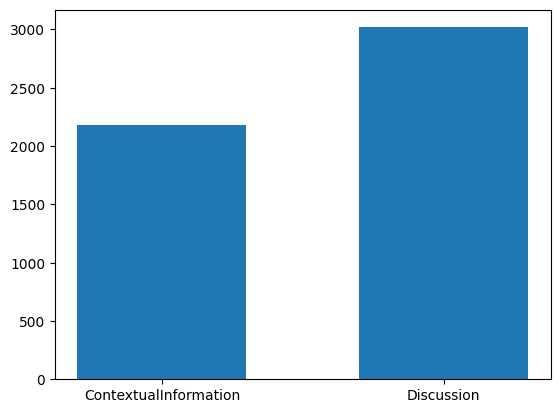

In [ ]:
# Visualize w/ bar graph
Other = ["ContextualInformation", "Discussion"]
Other_count = [informative_tweets.ContextualInformation.sum(), informative_tweets.Discussion.sum()]

plt.bar(Other, Other_count, width=0.6)

In [ ]:
y_other = informative_tweets[Other]

In [ ]:
X_train_other, X_test_other, y_train_other, y_test_other = train_test_split(Xfeatures, y_other, test_size=0.2, random_state=42)

In [ ]:
BinaryRelevance(classifier=MultinomialNB(alpha=1.0, class_prior=None,
                                         fit_prior=True),
                require_dense=[True, True])

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
# Convert multi-label problem to a multi-class problem
#binary_rel_clf = BinaryRelevance(MultinomialNB()) # Naive Bayes algorithm method used for classification

# We fit the model into the dataset to recognize patterns from the dataset
binary_rel_clf.fit(X_train_other,y_train_other)
#We test our model using the test data. We see if the model can make a prediction using the test data.
br_prediction_other = binary_rel_clf.predict(X_test_other)
br_prediction_other.toarray()

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

In [ ]:
# Get the accuracy score
accuracy_score(y_test_other,br_prediction_other)

0.8663382072472982

In [ ]:
#Hamming loss is the fraction of labels that are incorrectly predicted.
hamming_loss(y_test_other,br_prediction_other)

0.067546090273363

In [ ]:
clf_chain_model_other = build_model(MultinomialNB(),ClassifierChain,X_train_other,y_train_other,X_test_other,y_test_other)
clf_chain_model_other

{'accuracy:': 0.8658614113159567, 'hamming_score': 0.08034011443102353}

####Report

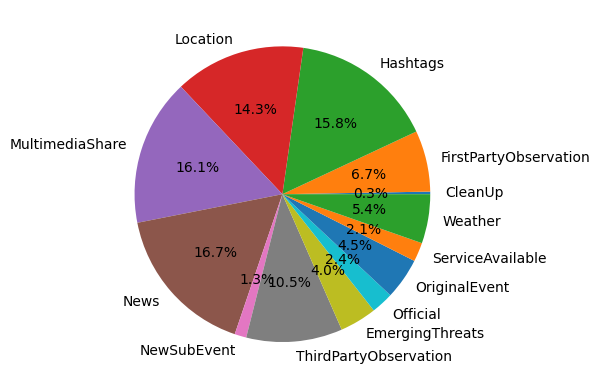

In [ ]:
Report = ["CleanUp", "FirstPartyObservation", "Hashtags", "Location",
          "MultimediaShare", "News", "NewSubEvent", "ThirdPartyObservation",
          "EmergingThreats", "Official", "OriginalEvent", "ServiceAvailable", "Weather"]

# Visualize w/ bar graph
Report_count = [informative_tweets.CleanUp.sum(), informative_tweets.FirstPartyObservation.sum(), informative_tweets.Hashtags.sum(),
                informative_tweets.Location.sum(), informative_tweets.MultimediaShare.sum(), informative_tweets.News.sum(),
                informative_tweets.NewSubEvent.sum(), informative_tweets.ThirdPartyObservation.sum(), informative_tweets.EmergingThreats.sum(),
                informative_tweets.Official.sum(), informative_tweets.OriginalEvent.sum(), informative_tweets.ServiceAvailable.sum(),
                informative_tweets.Weather.sum()]

#plt.bar(Report, Report_count)

fig, ax = plt.subplots()
ax.pie(Report_count, labels=Report, autopct='%1.1f%%')
#figure(figsize=(20, 10), dpi=80)
plt.rcParams["figure.figsize"] = (50,6)

In [ ]:
Report_count
# Majority: Hashtags, location, multimediashare, news ar ethe most
# Minority: NewSubEvent, EmergingThreats, Official, OriginalEvent, ServiceAvailable, Weather, CleanUp, FirstPartyObservation

[186, 4435, 10459, 9491, 10647, 11061, 853, 6969, 2676, 1607, 2999, 1379, 3562]

In [ ]:
y_report_uns = informative_tweets[Report]

In [ ]:
X_train_uns, X_test_uns, y_train_uns, y_test_uns = train_test_split(Xfeatures, y_report_uns, test_size=0.2, random_state=42)

In [ ]:
# Convert multi-label problem to a multi-class problem
binary_rel_clf = BinaryRelevance(MultinomialNB())

# We fit the model into the dataset to recognize patterns from the dataset
binary_rel_clf.fit(X_train_uns,y_train_uns)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
#We test our model using the test data. We see if the model can make a prediction using the test data.
br_prediction = binary_rel_clf.predict(X_test_uns)
br_prediction.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
clf_chain_model = build_model(MultinomialNB(),ClassifierChain,X_train_uns,y_train_uns,X_test_uns,y_test_uns)
clf_chain_model

{'accuracy:': 0.19500953591862683, 'hamming_score': 0.12386913785515184}

####Request

In [ ]:
y_report_uns = informative_tweets[Request]

In [ ]:
X_train_uns, X_test_uns, y_train_uns, y_test_uns = train_test_split(Xfeatures, y_report_uns, test_size=0.2, random_state=42)

In [ ]:
# Convert multi-label problem to a multi-class problem
binary_rel_clf = BinaryRelevance(MultinomialNB())

# We fit the model into the dataset to recognize patterns from the dataset
binary_rel_clf.fit(X_train_uns,y_train_uns)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
#We test our model using the test data. We see if the model can make a prediction using the test data.
br_prediction = binary_rel_clf.predict(X_test_uns)
br_prediction.toarray()

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [ ]:
clf_chain_model = build_model(MultinomialNB(),ClassifierChain,X_train_uns,y_train_uns,X_test_uns,y_test_uns)
clf_chain_model

{'accuracy:': 0.981404958677686, 'hamming_score': 0.006516211061665607}

### 6.3) Combine miniority classes

In [ ]:
taskCategories = [
    "CallToAction-Donations", #0
    "CallToAction-MovePeople",#1
    "CallToAction-Volunteer",#2
    "Other-ContextualInformation",#3
    "Other-Discussion",#4
    "Report-CleanUp",#5
    "Report-EmergingThreats",#6
    "Report-FirstPartyObservation",#7
    "Report-Hashtags",#8
    "Report-Location",#9
    "Report-MultimediaShare",#10
    "Report-News",#11
    "Report-NewSubEvent",#12
    "Report-Official",#13
    "Report-OriginalEvent",#14
    "Report-ServiceAvailable",#15
    "Report-ThirdPartyObservation",#16
    "Report-Weather",#17
    "Request-GoodsServices",#18
    "Request-InformationWanted",#19
    "Request-SearchAndRescue",#20
]

In [ ]:
# Minority: NewSubEvent, EmergingThreats, Official, OriginalEvent, ServiceAvailable,
# Weather, CleanUp, FirstPartyObservation

# Action
informative_tweets['Donations'] = informative_tweets['categories'].str.contains(taskCategories[0]).astype(int)
informative_tweets['MovePeople'] = informative_tweets['categories'].str.contains(taskCategories[1]).astype(int)
informative_tweets['Volunteer'] = informative_tweets['categories'].str.contains(taskCategories[2]).astype(int)
# Other
informative_tweets['ContextualInformation'] = informative_tweets['categories'].str.contains(taskCategories[3]).astype(int)
informative_tweets['Discussion'] = informative_tweets['categories'].str.contains(taskCategories[4]).astype(int)
# Report
#Minority Class
informative_tweets['Minority_Class'] = informative_tweets['categories'].str.contains(taskCategories[5]).astype(int)
informative_tweets['Minority_Class'] = informative_tweets['categories'].str.contains(taskCategories[6]).astype(int)
informative_tweets['Minority_Class'] = informative_tweets['categories'].str.contains(taskCategories[7]).astype(int)
informative_tweets['Minority_Class'] = informative_tweets['categories'].str.contains(taskCategories[12]).astype(int)
informative_tweets['Minority_Class'] = informative_tweets['categories'].str.contains(taskCategories[13]).astype(int)
informative_tweets['Minority_Class'] = informative_tweets['categories'].str.contains(taskCategories[14]).astype(int)
informative_tweets['Minority_Class'] = informative_tweets['categories'].str.contains(taskCategories[15]).astype(int)
informative_tweets['Minority_Class'] = informative_tweets['categories'].str.contains(taskCategories[17]).astype(int)

# informative_tweets['CleanUp'] = informative_tweets['categories'].str.contains(taskCategories[5]).astype(int) #
# informative_tweets['EmergingThreats'] = informative_tweets['categories'].str.contains(taskCategories[6]).astype(int) #
# informative_tweets['FirstPartyObservation'] = informative_tweets['categories'].str.contains(taskCategories[7]).astype(int) #
informative_tweets['Hashtags'] = informative_tweets['categories'].str.contains(taskCategories[8]).astype(int)
informative_tweets['Location'] = informative_tweets['categories'].str.contains(taskCategories[9]).astype(int)
informative_tweets['MultimediaShare'] = informative_tweets['categories'].str.contains(taskCategories[10]).astype(int)
informative_tweets['News'] = informative_tweets['categories'].str.contains(taskCategories[11]).astype(int)
# informative_tweets['NewSubEvent'] = informative_tweets['categories'].str.contains(taskCategories[12]).astype(int) #
# informative_tweets['Official'] = informative_tweets['categories'].str.contains(taskCategories[13]).astype(int) #
# informative_tweets['OriginalEvent'] = informative_tweets['categories'].str.contains(taskCategories[14]).astype(int) #
# informative_tweets['ServiceAvailable'] = informative_tweets['categories'].str.contains(taskCategories[15]).astype(int) #
informative_tweets['ThirdPartyObservation'] = informative_tweets['categories'].str.contains(taskCategories[16]).astype(int)
# informative_tweets['Weather'] = informative_tweets['categories'].str.contains(taskCategories[17]).astype(int) #
# Request
informative_tweets['GoodsServices'] = informative_tweets['categories'].str.contains(taskCategories[18]).astype(int)
informative_tweets['InformationWanted'] = informative_tweets['categories'].str.contains(taskCategories[19]).astype(int)
informative_tweets['SearchAndRescue'] = informative_tweets['categories'].str.contains(taskCategories[20]).astype(int)

<ipython-input-70-03538718855e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_tweets['Donations'] = informative_tweets['categories'].str.contains(taskCategories[0]).astype(int)
<ipython-input-70-03538718855e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_tweets['MovePeople'] = informative_tweets['categories'].str.contains(taskCategories[1]).astype(int)
<ipython-input-70-03538718855e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [ ]:
## Removed less useful labels:
# Other - Advice, Irrelevant, Sentiment
# Report - Factoid

CallToAction = ["Donations", "MovePeople", "Volunteer"]

#Other = ["Advice", "ContextualInformation", "Discussion", "Irrelevant", "Sentiment"]
Other = ["ContextualInformation", "Discussion"]

#news & observations
# Report1 = ["CleanUp", "Factoid", "FirstPartyObservation", "Hashtags", "Location",
#           "MultimediaShare", "News", "NewSubEvent", "ThirdPartyObservation"]

#real experience
# Report2 = ["EmergingThreats", "Official", "OriginalEvent", "ServiceAvailable", "Weather"]

# Report = ["CleanUp", "FirstPartyObservation", "Hashtags", "Location",
#           "MultimediaShare", "News", "NewSubEvent", "ThirdPartyObservation",
#           "EmergingThreats", "Official", "OriginalEvent", "ServiceAvailable", "Weather"]

Report = ["Minority_Class", "Hashtags", "Location",
          "MultimediaShare", "News", "ThirdPartyObservation"]

Request = ["GoodsServices", "InformationWanted", "SearchAndRescue"]

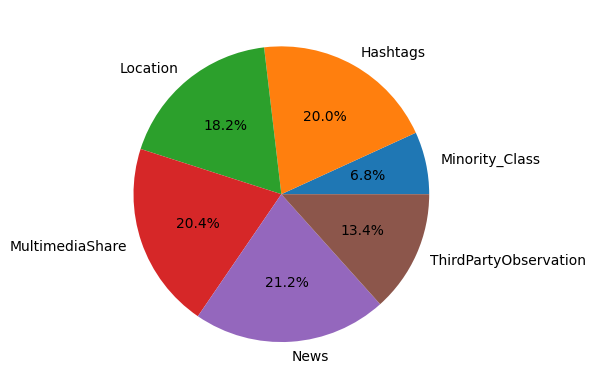

In [ ]:
# Visualize w/ bar graph
min_class =["Minority_Class", "Hashtags", "Location",
          "MultimediaShare", "News", "ThirdPartyObservation"]
min_class_count = [informative_tweets.Minority_Class.sum(), informative_tweets.Hashtags.sum(),
                   informative_tweets.Location.sum(), informative_tweets.MultimediaShare.sum(),
                   informative_tweets.News.sum(), informative_tweets.ThirdPartyObservation.sum()]

#plt.bar(min_class, min_class_count, width=0.6)
fig, ax = plt.subplots()
ax.pie(min_class_count, labels=min_class, autopct='%1.1f%%')
#figure(figsize=(20, 10), dpi=80)
plt.rcParams["figure.figsize"] = (50,6)

####CallToAction

In [ ]:
y_min_class = informative_tweets[CallToAction]

In [ ]:
X_train_min_class, X_test_min_class, y_train_min_class, y_test_min_class = train_test_split(Xfeatures, y_min_class, test_size=0.2, random_state=42)

In [ ]:
# Convert multi-label problem to a multi-class problem
binary_rel_clf = BinaryRelevance(MultinomialNB())

# We fit the model into the dataset to recognize patterns from the dataset
binary_rel_clf.fit(X_train_min_class,y_train_min_class)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
#We test our model using the test data. We see if the model can make a prediction using the test data.
br_prediction = binary_rel_clf.predict(X_test_min_class)
br_prediction.toarray()

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [ ]:
clf_chain_model = build_model(MultinomialNB(),ClassifierChain,X_train_min_class,y_train_min_class,X_test_min_class,y_test_min_class)
clf_chain_model

{'accuracy:': 0.9593134138588684, 'hamming_score': 0.014038991311718584}

####Other

In [ ]:
y_min_class = informative_tweets[Other]

In [ ]:
X_train_min_class, X_test_min_class, y_train_min_class, y_test_min_class = train_test_split(Xfeatures, y_min_class, test_size=0.2, random_state=42)

In [ ]:
# Convert multi-label problem to a multi-class problem
binary_rel_clf = BinaryRelevance(MultinomialNB())

# We fit the model into the dataset to recognize patterns from the dataset
binary_rel_clf.fit(X_train_min_class,y_train_min_class)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
#We test our model using the test data. We see if the model can make a prediction using the test data.
br_prediction = binary_rel_clf.predict(X_test_min_class)
br_prediction.toarray()

array([[0, 0],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 0]])

In [ ]:
clf_chain_model = build_model(MultinomialNB(),ClassifierChain,X_train_min_class,y_train_min_class,X_test_min_class,y_test_min_class)
clf_chain_model

{'accuracy:': 0.8658614113159567, 'hamming_score': 0.08034011443102353}

####Report

In [ ]:
# ['CleanUp', 'FirstPartyObservation', 'EmergingThreats', 'Official', 'OriginalEvent', 'ServiceAvailable', 'Weather']
y_min_class = informative_tweets[Report]

In [ ]:
X_train_min_class, X_test_min_class, y_train_min_class, y_test_min_class = train_test_split(Xfeatures, y_min_class, test_size=0.2, random_state=42)

In [ ]:
BinaryRelevance(classifier=MultinomialNB(alpha=1.0, class_prior=None,
                                         fit_prior=True),
                require_dense=[True, True])

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [ ]:
# Convert multi-label problem to a multi-class problem
binary_rel_clf = BinaryRelevance(MultinomialNB())
# We fit the model into the dataset to recognize patterns from the dataset
binary_rel_clf.fit(X_train_min_class,y_train_min_class)
# We test our model using the test data. We see if the model can make a prediction using the test data.
br_prediction_min_class = binary_rel_clf.predict(X_test_min_class)
br_prediction_min_class.toarray()

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0]])

In [ ]:
clf_chain_model_min_class = build_model(MultinomialNB(),ClassifierChain,X_train_min_class,y_train_min_class,X_test_min_class,y_test_min_class)
clf_chain_model_min_class

{'accuracy:': 0.3278766687857597, 'hamming_score': 0.19654587836406018}

####Request

<BarContainer object of 3 artists>

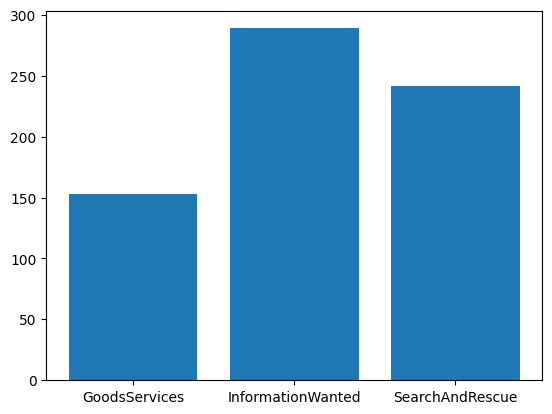

In [ ]:
Request = ["GoodsServices", "InformationWanted", "SearchAndRescue"]

# Visualize w/ bar graph
Request_count = [informative_tweets.GoodsServices.sum(), informative_tweets.InformationWanted.sum(), informative_tweets.SearchAndRescue.sum()]

plt.bar(Request, Request_count)

In [ ]:
y_request = informative_tweets[Request]

In [ ]:
X_train_request, X_test_request, y_train_request, y_test_request = train_test_split(Xfeatures, y_request, test_size=0.2, random_state=42)

In [ ]:
BinaryRelevance(classifier=MultinomialNB(alpha=1.0, class_prior=None,
                                         fit_prior=True),
                require_dense=[True, True])

In [ ]:
# Convert multi-label problem to a multi-class problem

# We fit the model into the dataset to recognize patterns from the dataset
binary_rel_clf.fit(X_train_request,y_train_request)
# We test our model using the test data. We see if the model can make a prediction using the test data.
br_prediction_request = binary_rel_clf.predict(X_test_request)
br_prediction_request.toarray()

In [ ]:
# Get the accuracy score
accuracy_score(y_test_request,br_prediction_request)

0.9024157660521297

In [ ]:
#Hamming loss is the fraction of labels that are incorrectly predicted.
hamming_loss(y_test_request,br_prediction_request)

0.03268700995973723

In [ ]:
clf_chain_model_request = build_model(MultinomialNB(),ClassifierChain,X_train_request,y_train_request,X_test_request,y_test_request)
clf_chain_model_request

{'accuracy:': 0.9024157660521297, 'hamming_score': 0.03268700995973723}

#BERT

####BERT - Disaster Type

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
#tokenize random sentence
token = tokenizer.encode_plus(
    #df['Phrase'].iloc[0],
    informative_tweets['tweet_lem'].iloc[0],
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)


In [ ]:
token.input_ids

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101,  6307, 13865,   185, 20473,  9717, 18351,  1116,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [ ]:
X_input_ids = np.zeros((len(informative_tweets), 256))
X_attn_masks = np.zeros((len(informative_tweets), 256))

In [ ]:
from tqdm.auto import tqdm

def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(informative_tweets['disaster_type'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
X_input_ids, X_attn_masks = generate_training_data(informative_tweets, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [ ]:
labels[np.arange(len(informative_tweets)), informative_tweets['disaster_type'].values] = 1 # one-hot encoded target tensor

<ipython-input-111-066b57bbf22a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels[np.arange(len(informative_tweets)), informative_tweets['disaster_type'].values] = 1 # one-hot encoded target tensor


KeyError: ignored

####Attempt 3 from: [Multiclass Bert towardsdatasci](https://)

In [ ]:
informative_tweets.head()

,event_id,post_id,text,categories,priority,timestamp,not_informative,tweet_clean,crisis_name_ID,disaster_type,tweet_token,text_string,tweet_fdist,tweet_lem,inform_or_not_ID,disaster_type_ID
0,typhoonHagupit2014,541638434994266112,Photo: Prayers for the Philippines! #Hagupit h...,"Report-FirstPartyObservation,Report-Multimedia...",0,2018-09-24 16:03:31+00:00,0,photo prayers for the philippines,0,Hurricane,"[photo, prayers, philippines]",photo prayers philippines,photo prayers philippines,photo prayers philippines,0,0
2,fireYMM2016,727137040362426368,Smoke has really thickened over #ymm in the pa...,"Report-MultimediaShare,Report-Hashtags",0,2019-04-05 16:38:51+00:00,0,smoke has really thickened over in the past ho...,2,Fire,"[smoke, really, thickened, past, hour, still, ...",smoke really thickened past hour still big plu...,smoke really thickened past hour still big plu...,smoke really thickened past hour still big plu...,0,1
4,fireYMM2016,727577686437044224,Crews from Lesser Slave Lake department are he...,"Report-MultimediaShare,Report-Hashtags,Report-...",0,2019-04-08 16:06:36+00:00,0,crews from lesser slave lake department are he...,2,Fire,"[crews, lesser, slave, lake, department, help,...",crews lesser slave lake department help local ...,crews lesser slave lake department help local ...,crews lesser slave lake department help local ...,0,1
5,shootingDallas2017,751245551644078080,Oh my Looky looky. #Trump supporters set Twitt...,"Report-Hashtags,Other-Sentiment",0,2019-04-08 12:14:54+00:00,0,oh my looky looky supporters set twitter ablaz...,4,Human Disaster,"[oh, looky, looky, supporters, set, twitter, a...",looky looky supporters set twitter ablaze shoo...,looky looky supporters set twitter ablaze shoo...,looky looky supporters set twitter ablaze shoo...,0,2
7,hurricaneFlorence2018,1041118708557643776,25% of proceeds from 9/15 to 9/21 will go to t...,"Report-MultimediaShare,Other-Discussion",0,2019-04-03 19:46:01+00:00,0,of proceeds from 15 to 21 will go to the caju...,1,Hurricane,"[proceeds, go, cajun, navy, help, folks, areas...",proceeds cajun navy help folks areas affected ...,proceeds cajun navy help folks areas affected ...,proceeds cajun navy help folks areas affected ...,0,0


In [ ]:
# Encode the labels
possible_labels = informative_tweets.disaster_type.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Hurricane': 0,
 'Fire': 1,
 'Human Disaster': 2,
 'Earthquake': 3,
 'Floods': 4,
 'Other': 5}

In [ ]:
# this already exists with disaster_type_id
informative_tweets['label_disas_type'] = informative_tweets.disaster_type.replace(label_dict)

<ipython-input-125-0bd2bb0c6110>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_tweets['label_disas_type'] = informative_tweets.disaster_type.replace(label_dict)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(informative_tweets.index.values,
                                                  informative_tweets.disaster_type_ID.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=informative_tweets.disaster_type_ID.values)

informative_tweets['data_type'] = ['not_set']*informative_tweets.shape[0]

informative_tweets.loc[X_train, 'data_type'] = 'train'
informative_tweets.loc[X_val, 'data_type'] = 'val'

#look at labl distribution
informative_tweets.groupby(['disaster_type', 'label_disas_type', 'data_type']).count()

<ipython-input-127-d96e6cb21f69>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_tweets['data_type'] = ['not_set']*informative_tweets.shape[0]


event_id  post_id  text  \
disaster_type  label_disas_type data_type                            
Earthquake     3                train          7066     7066  7066   
                                val            1416     1416  1416   
Fire           1                train          3705     3705  3705   
                                val             750      750   750   
Floods         4                train          3053     3053  3053   
                                val             623      623   623   
Human Disaster 2                train          5506     5506  5506   
                                val            1112     1112  1112   
Hurricane      0                train          6653     6653  6653   
                                val            1343     1343  1343   
Other          5                train           195      195   195   
                                val              36       36    36   

                                           categories  priority  timestamp  \
disaster_type  label_disas_type data_type                                    
Earthquake     3                train            7066      7066       7066   
                                val              1416      1416       1416   
Fire           1                train            3705      3705       3705   
                                val               750       750        750   
Floods         4                train            3053      3053       3053   
                                val               623       623        623   
Human Disaster 2                train            5506      5506       5506   
                                val              1112      1112       1112   
Hurricane      0                train            6653      6653       6653   
                                val              1343      1343       1343   
Other          5                train             195       195        195   
                                val                36        36         36   

                                           not_informative  tweet_clean  \
disaster_type  label_disas_type data_type                                 
Earthquake     3                train                 7066         7066   
                                val                   1416         1416   
Fire           1                train                 3705         3705   
                                val                    750          750   
Floods         4                train                 3053         3053   
                                val                    623          623   
Human Disaster 2                train                 5506         5506   
                                val                   1112         1112   
Hurricane      0                train                 6653         6653   
                                val                   1343         1343   
Other          5                train                  195          195   
                                val                     36           36   

                                           crisis_name_ID  tweet_token  \
disaster_type  label_disas_type data_type                                
Earthquake     3                train                7066         7066   
                                val                  1416         1416   
Fire           1                train                3705         3705   
                                val                   750          750   
Floods         4                train                3053         3053   
                                val                   623          623   
Human Disaster 2                train                5506         5506   
                                val                  1112         1112   
Hurricane      0                train                6653         6653   
                                val                  1343         1343   
Other          5              

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    informative_tweets[informative_tweets.data_type=='train'].tweet_lem.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    informative_tweets[informative_tweets.data_type=='val'].tweet_lem.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(informative_tweets[informative_tweets.data_type=='train'].label_disas_type.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(informative_tweets[informative_tweets.data_type=='val'].label_disas_type.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score

# Get performance metrics with f1 score & accuracy score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/8726 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
model.load_state_dict(torch.load('data_volume/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

FileNotFoundError: ignored

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
accuracy_per_class(predictions, true_vals)

Class: Hurricane
Accuracy: 1/1343

Class: Fire
Accuracy: 0/750

Class: Human Disaster
Accuracy: 1108/1112

Class: Earthquake
Accuracy: 0/1416

Class: Floods
Accuracy: 0/623

Class: Other
Accuracy: 0/36

